# Global Analysis

### Entrer le nom du fichier .CSV à analyser

In [5]:
filename = input()

 test_course_survey.csv 


### Préparation des données

In [6]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
from matplotlib.backends.backend_pdf import PdfPages

#data = pd.read_csv('test_course_survey.csv')
data = pd.read_csv(filename)

# Suppression des colonnes d'identification
data.drop(data.columns[[2,6,7,8]], axis=1, inplace=True)

colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf','#1a55FF']

def question (value):
    ''' Renvoie le texte d'une question
        Q02_rating->2- The course's content was clear and the objectives were achieved
    '''
    regex = re.compile('\d+\s?[-–] ')
    return regex.split(value)[1];

# from https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html

def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta
 
def MultiPie(mydf,mytitle):
    # défini le nb de colonnes
    if mydf.shape[1] == 1 :
        ncols = 1
    #elif (mydf.shape[1]<7):
    #    ncols = 2
    else :
        ncols = 3

    # calcul du nb de ligne
    if mydf.shape[1]%ncols ==0:
        nrows = int(mydf.shape[1]/ncols)
    else:
        nrows = int(mydf.shape[1]/ncols)+1

    #print(f"{mytitle}\nLen:{len(mydf)}\nShape[1]:{mydf.shape[1]}\nncols:{ncols}\nnrows{nrows}")
    fig, axs = plt.subplots(figsize=(20,20), nrows=nrows, ncols=ncols, squeeze=False)
    #fig.subplots_adjust(wspace=0.25,hspace=0.25,top=0.8,bottom=0.1)
    fig.subplots_adjust(top=0.8)
     
    colors = ['#00CD0D','#FFD700','#FF0700','#3f3075','#9467bd','#3301B5','#e377c2','#7f7f7f','#bcbd22','#17becf','#1a55FF']

    for ax, (title,values) in zip(axs.flat, mydf.items()):
        
        ax.pie(values,labels=[k for k,v in mydf.iterrows()],
            autopct = lambda p : f"{p:.2f}%  ({(p * sum(values)/100):,.0f})" if p > 0 else '',
            wedgeprops={'linewidth': 1, 'edgecolor':'white'},
            textprops={'color':"w",'weight':'bold'},
           colors = colors)
        
        if type(title) is tuple:
            figtitle = ''
            for t in title:
                figtitle +=t +'\n'
        else:
            figtitle = title
        
        ax.set_title(figtitle, weight='bold',size='large',position=(0.5,1.1), horizontalalignment ='center',verticalalignment='center')
        #ax.legend(loc='center left', bbox_to_anchor=(0,0.8))
    
    fig.suptitle(mytitle,fontsize=16, verticalalignment='top', horizontalalignment='center')
    #fig.suptitle(mytitle,fontsize=16,y=0.98, horizontalalignment='center')
    
    # récupère la légende et la place sur la figure
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels,  bbox_to_anchor=(0,0.8))
    
    # supprime les derniers graphes vides
    if mydf.shape[1]%ncols != 0:
        #print(f"{mytitle}*{newtitle}\nLen:{len(mydf)}\nShape[1]:{mydf.shape[1]}\nncols:{ncols}\nnrows{nrows}")
        for n in range(ncols,mydf.shape[1] %ncols,-1):
            #print(f"Delete axs[{nrows-1},{n-1}]")
            fig.delaxes(axs[nrows-1,n-1])
         
    #fig.tight_layout()
    fig.tight_layout(pad=2.0)
    fig.show()
    #fig.savefig(mytitle, dpi=100, transparent=True, bbox_inches='tight')
    return fig

def QPie(question,maxpage, pdf):
    mydf = data[[q for q in data.columns if question in q][0]].value_counts().sort_index(ascending=True).to_frame()
    myfig = MultiPie(mydf,[q for q in data.columns if question in q][0])
    pdf.savefig(myfig, bbox_inches="tight")

    # dessine Q1 par cours
    #mydf = data.pivot_table(index=[q for q in data.columns if question in q][0],columns=['Cours','Groupe'],aggfunc='size',fill_value=0)
    mydf = data.pivot_table(index=[q for q in data.columns if question in q][0],columns=['Cours'],aggfunc='size',fill_value=0)
    # découpe le DF pour les images
    for i in range(0,mydf.shape[1],maxpage):    
        myfig = MultiPie(mydf.iloc[:, i:(i+maxpage) ],[q for q in data.columns if question in q][0])
        pdf.savefig(myfig, bbox_inches="tight")

### Transformation des données Q5

In [7]:
# transforme Q5  en True / False
data[[q for q in data.columns if 'Q05' in q][0]] = data[[q for q in data.columns if 'Q05' in q][0]].astype(bool)

### Création du PDF

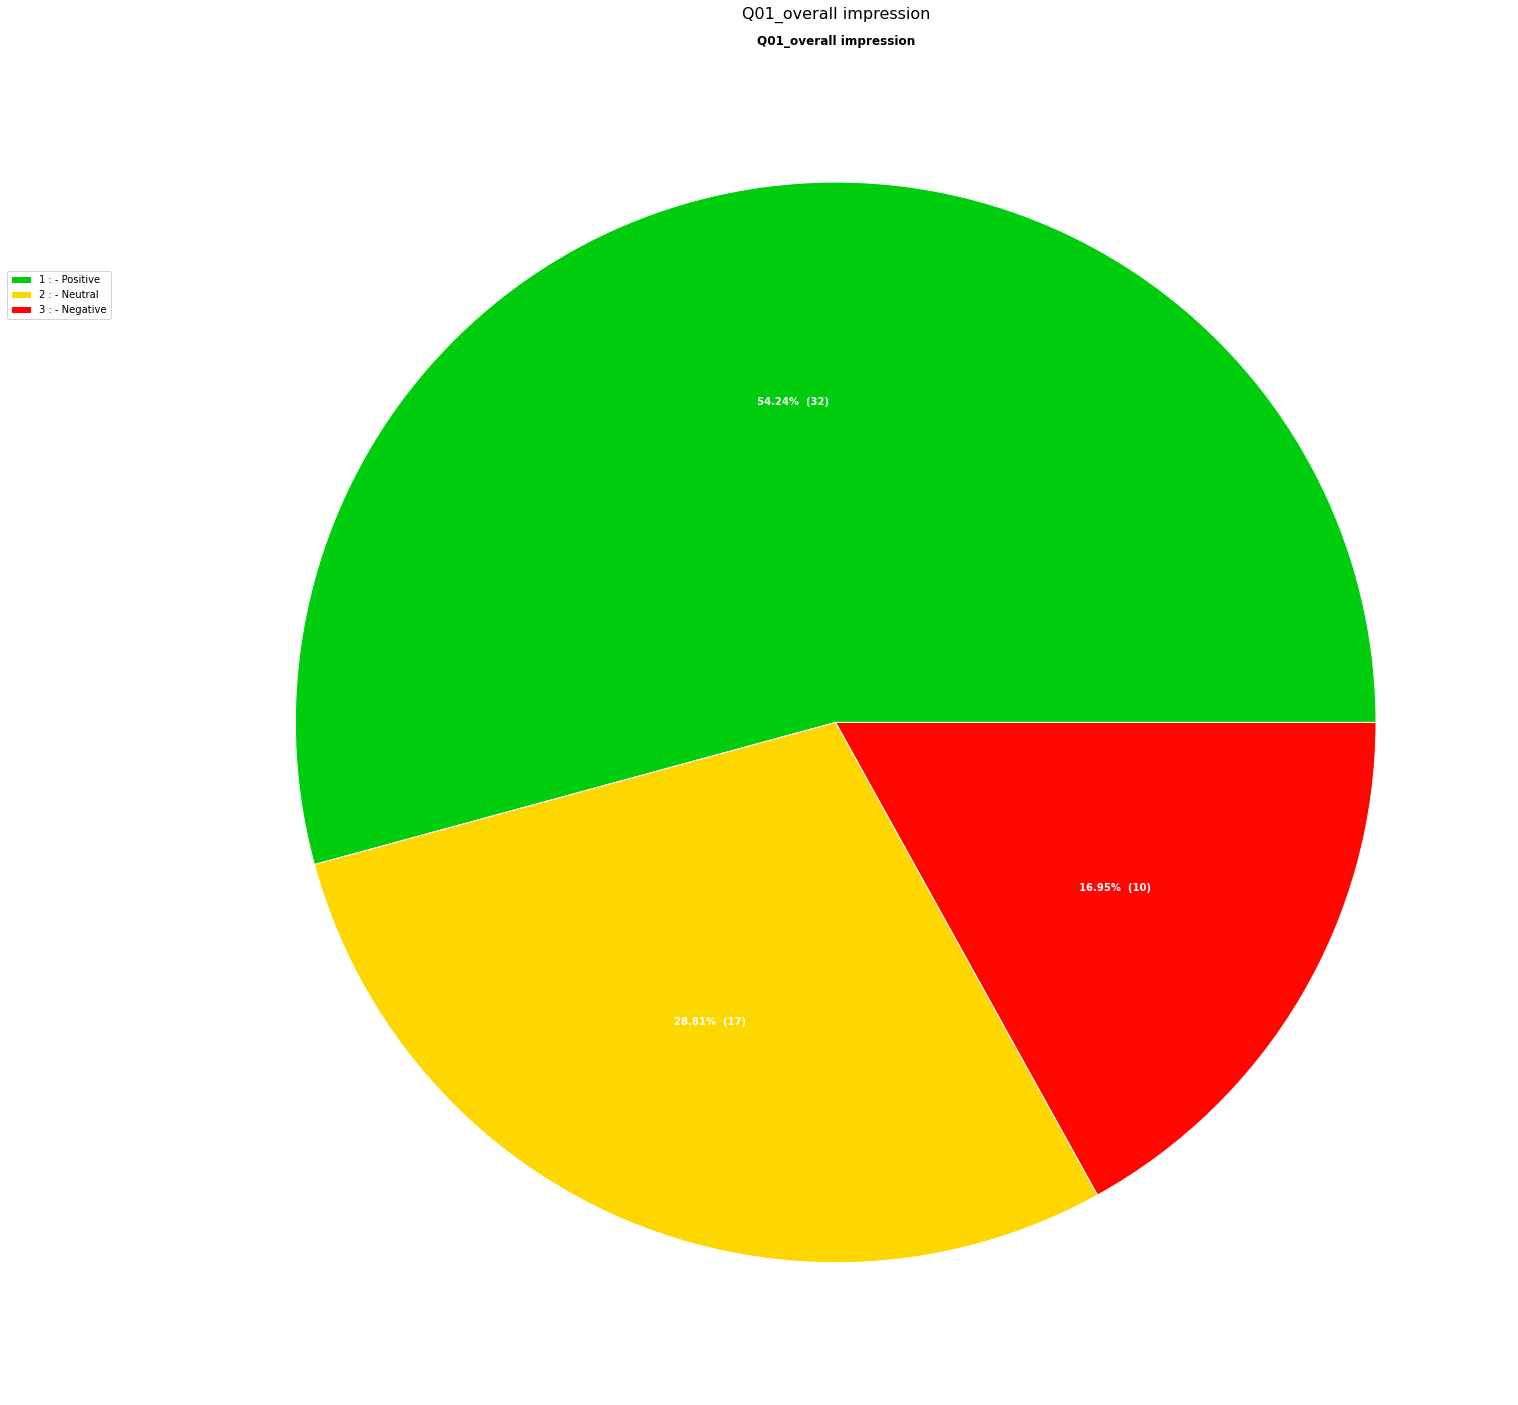

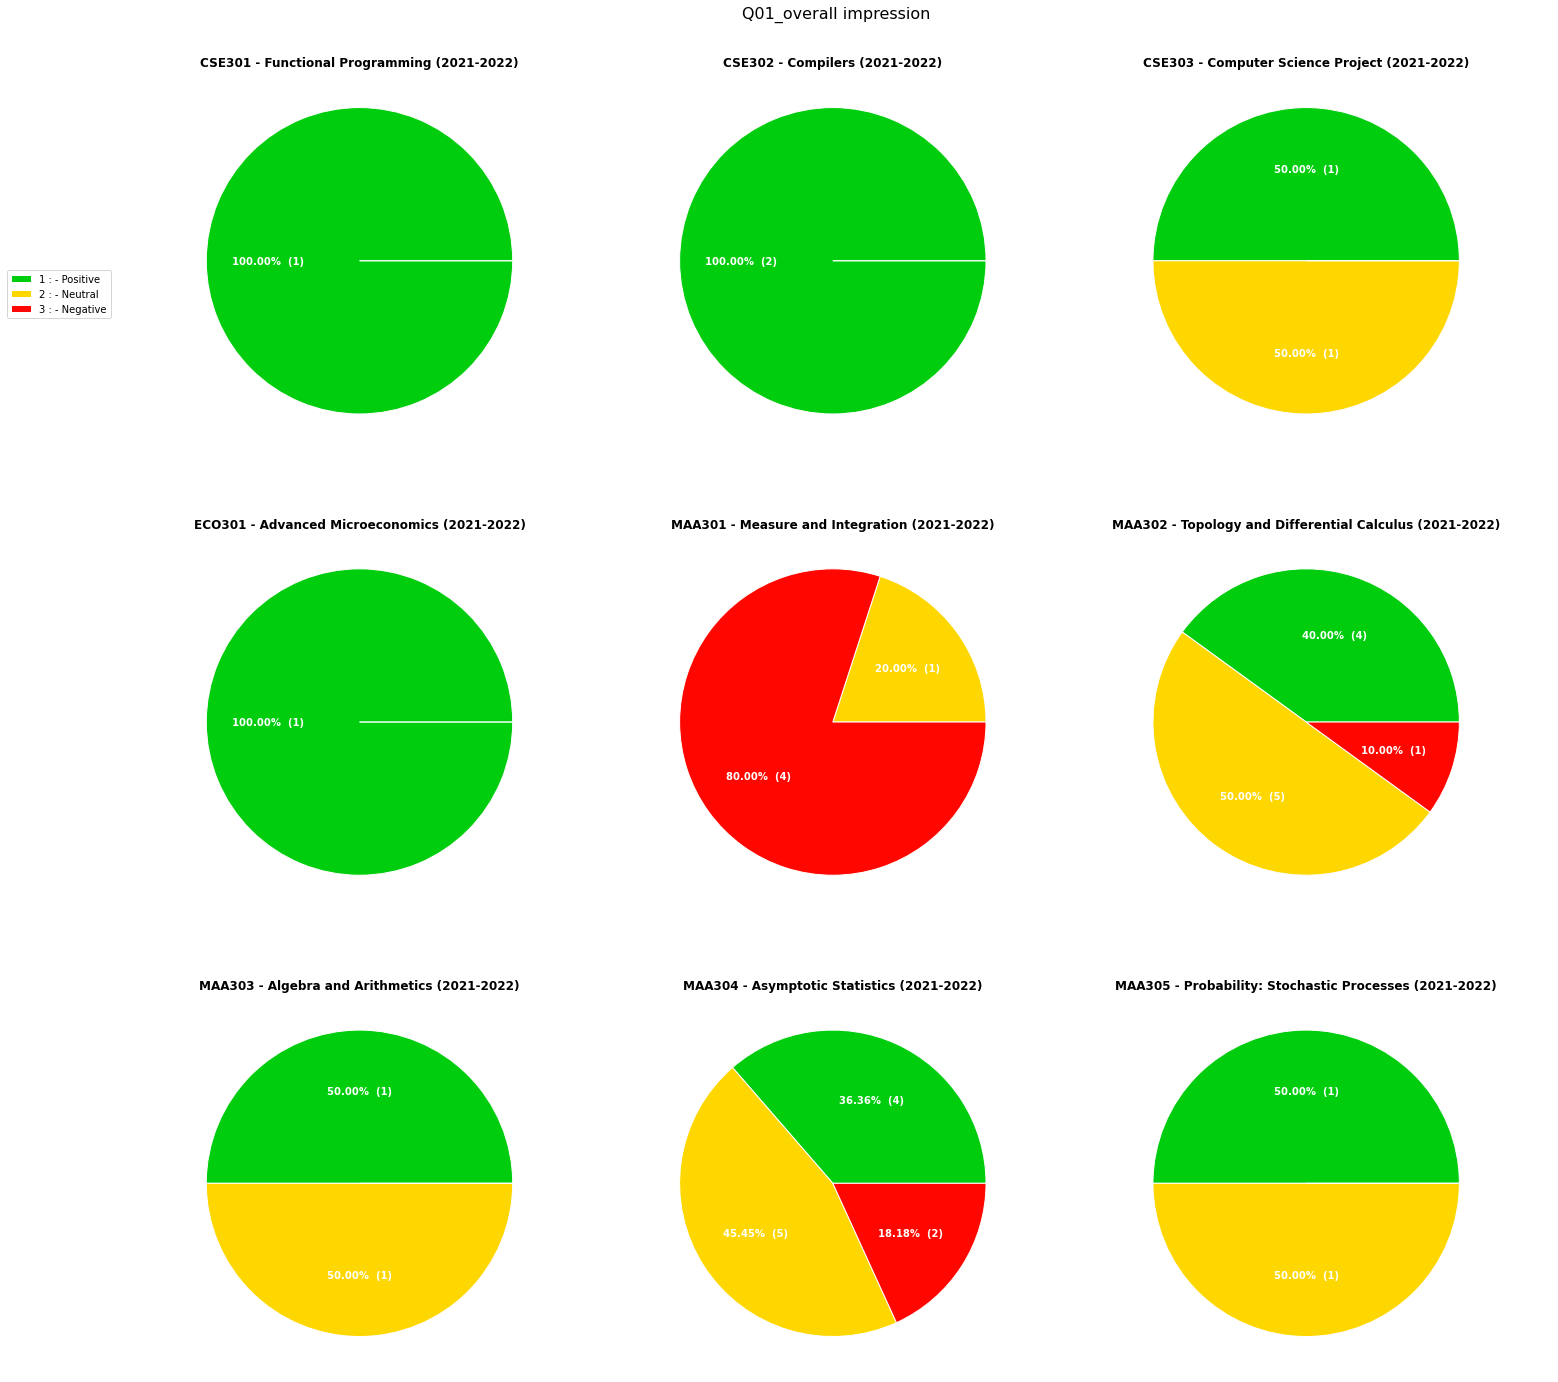

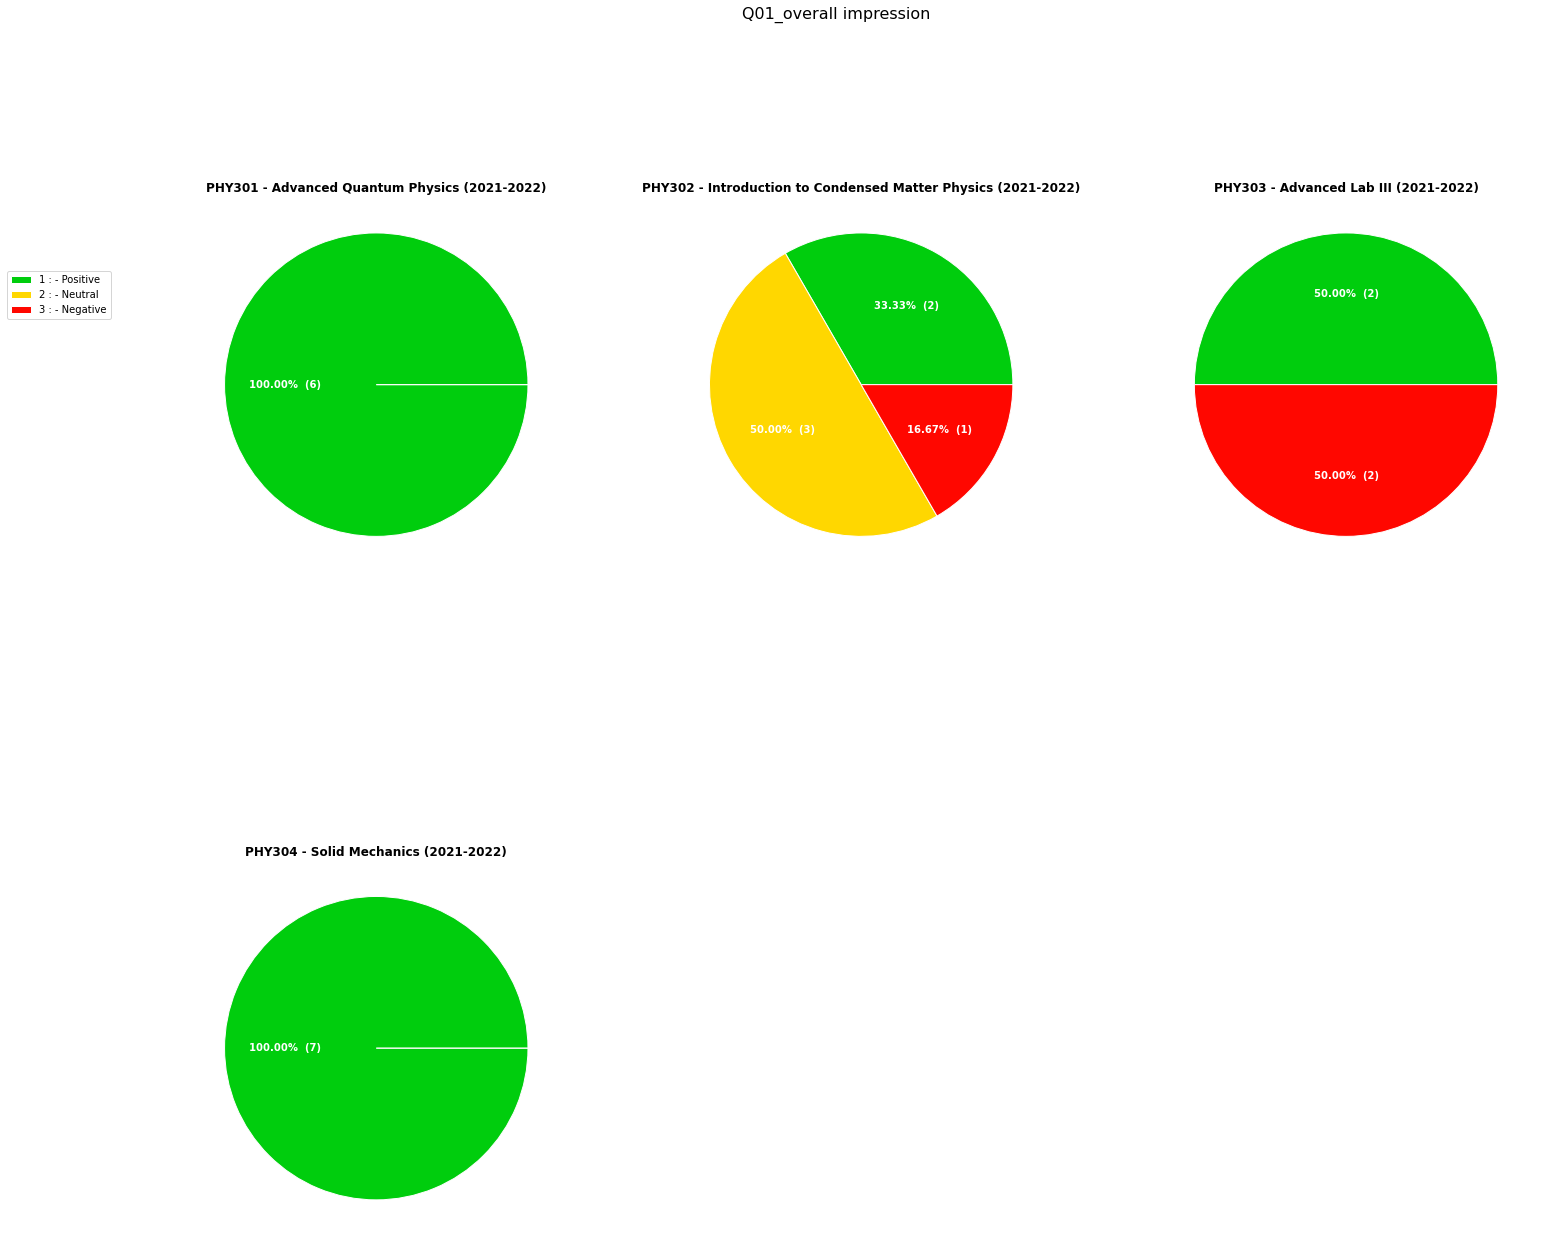

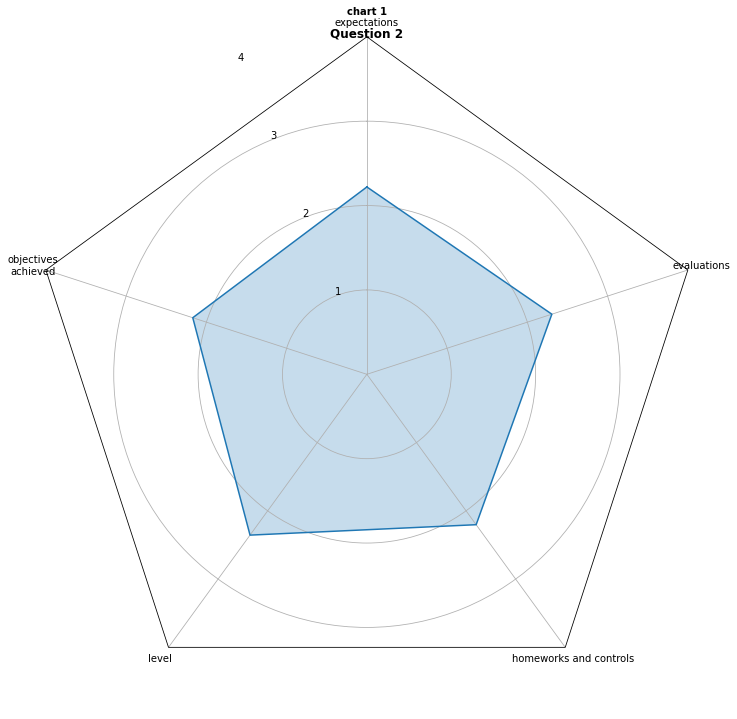

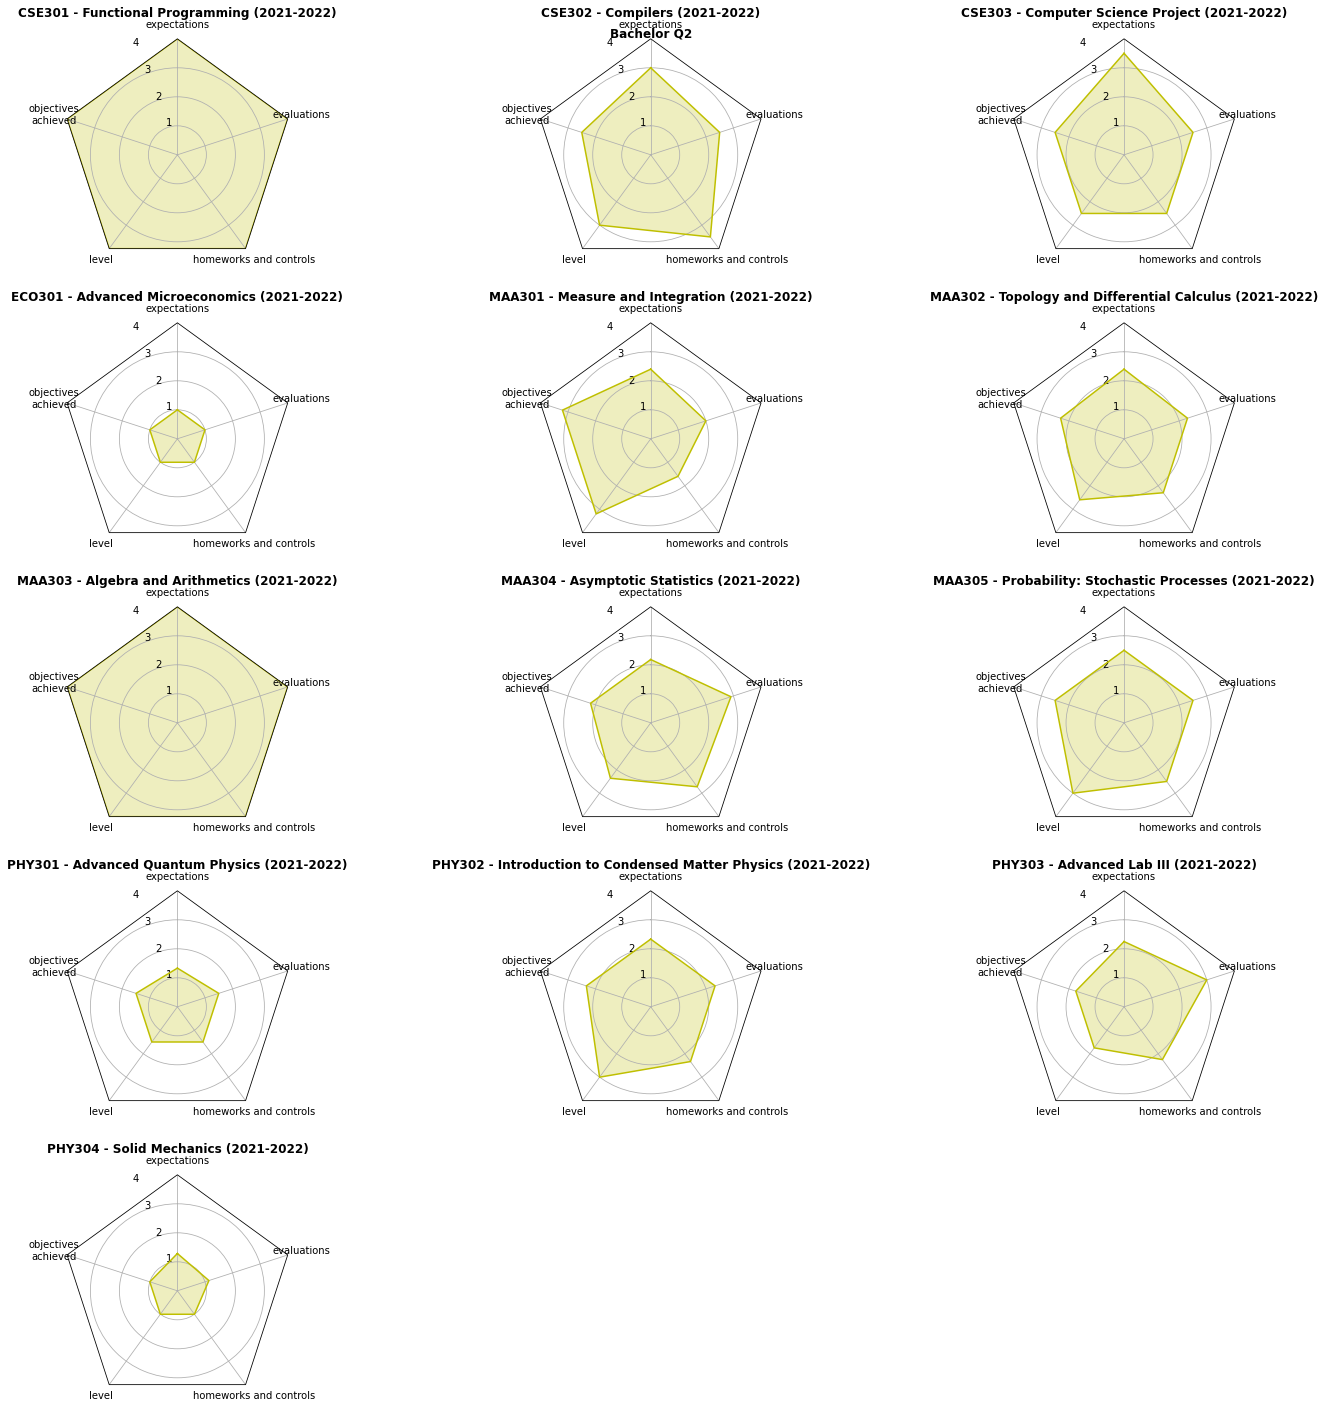

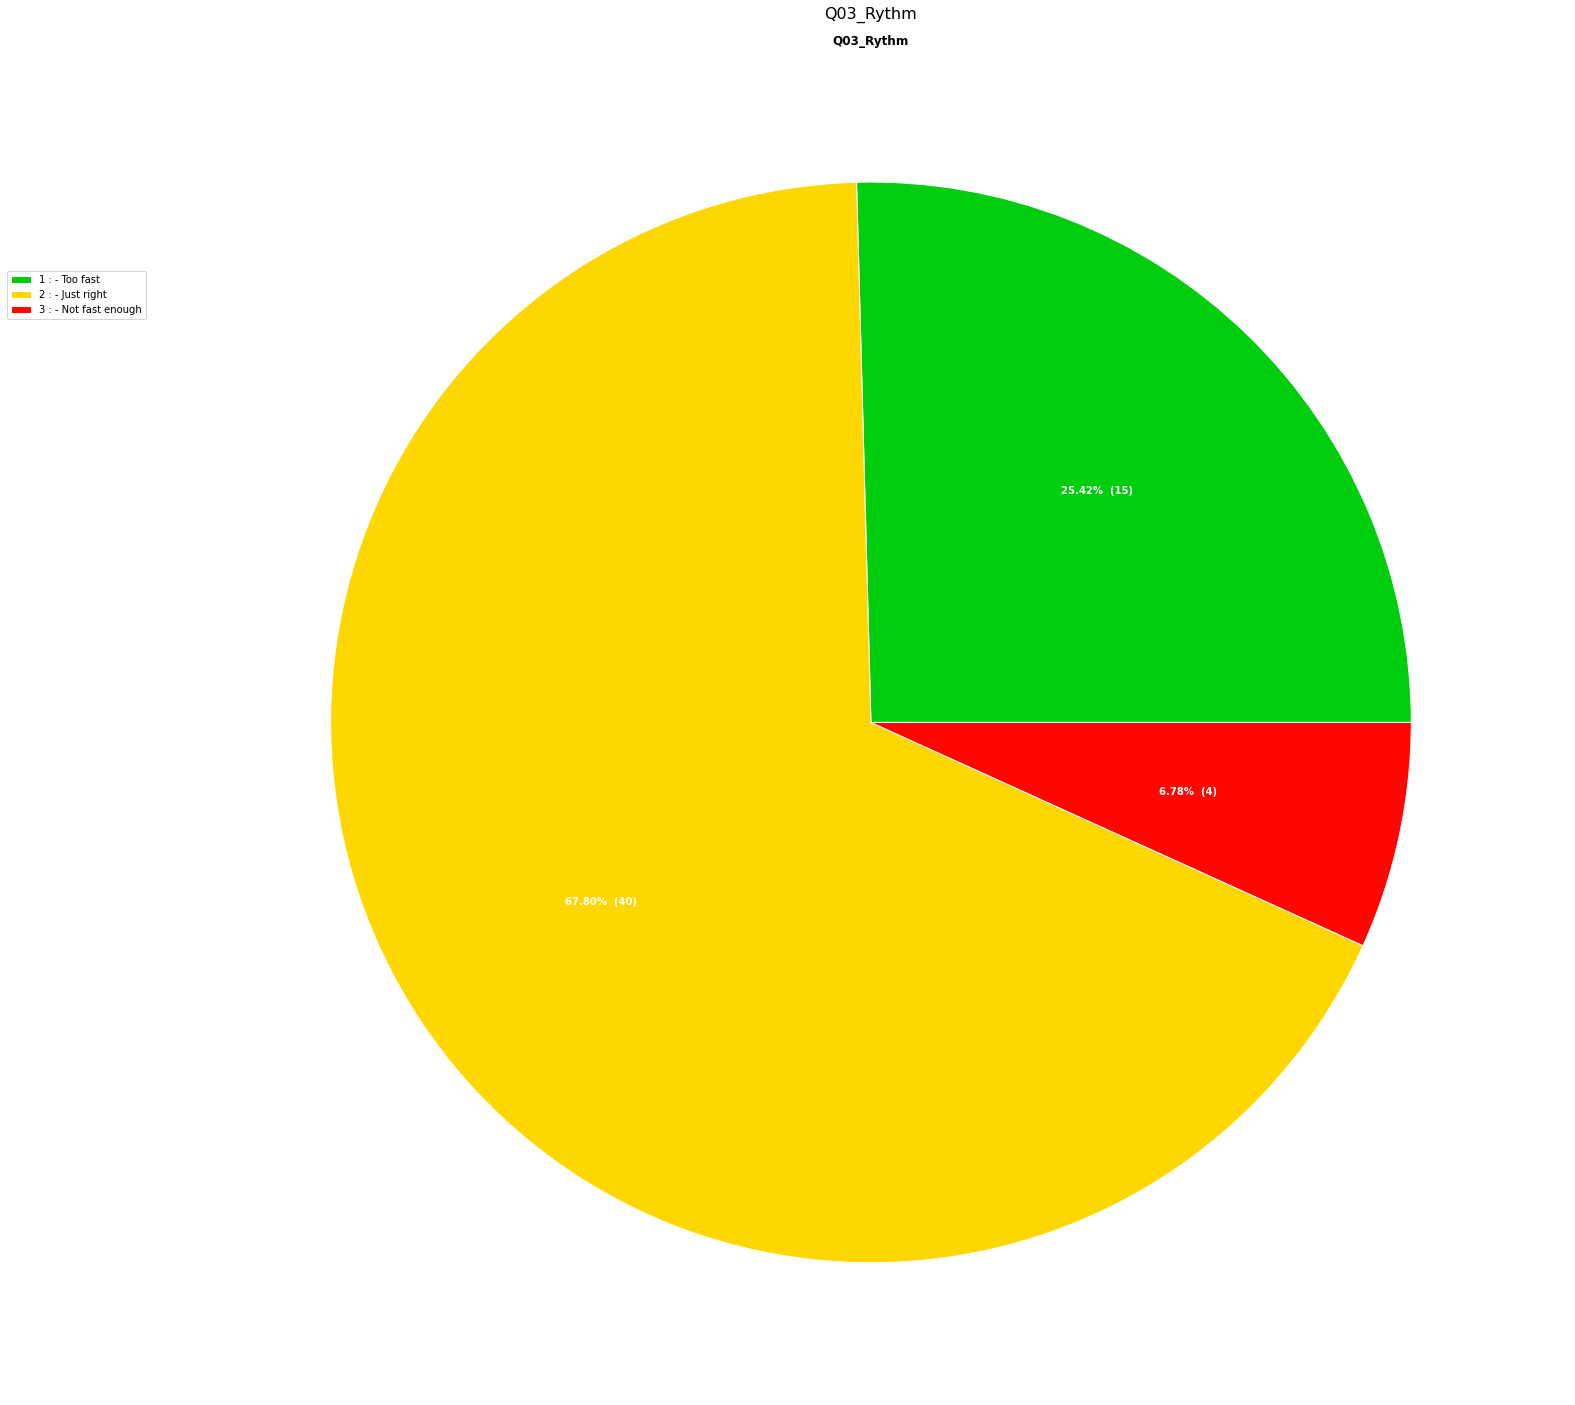

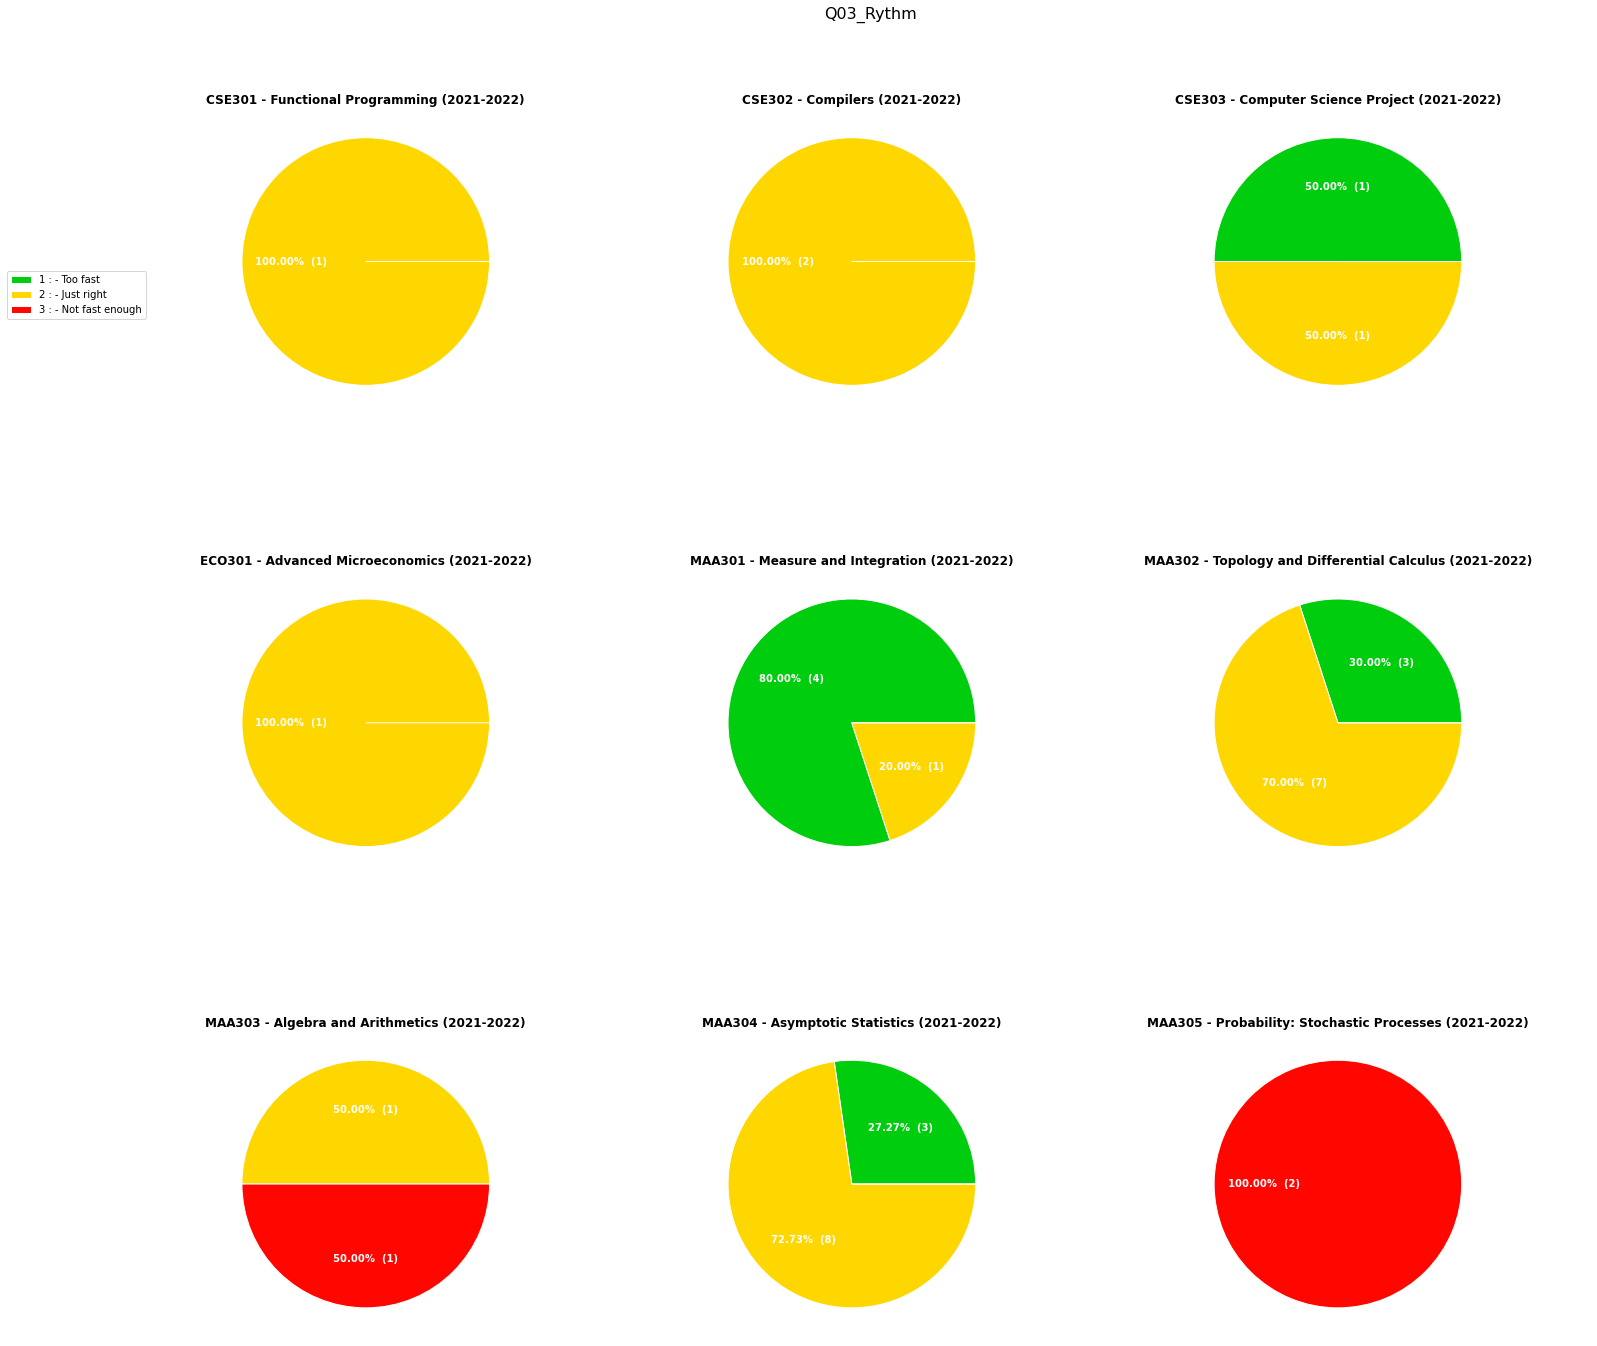

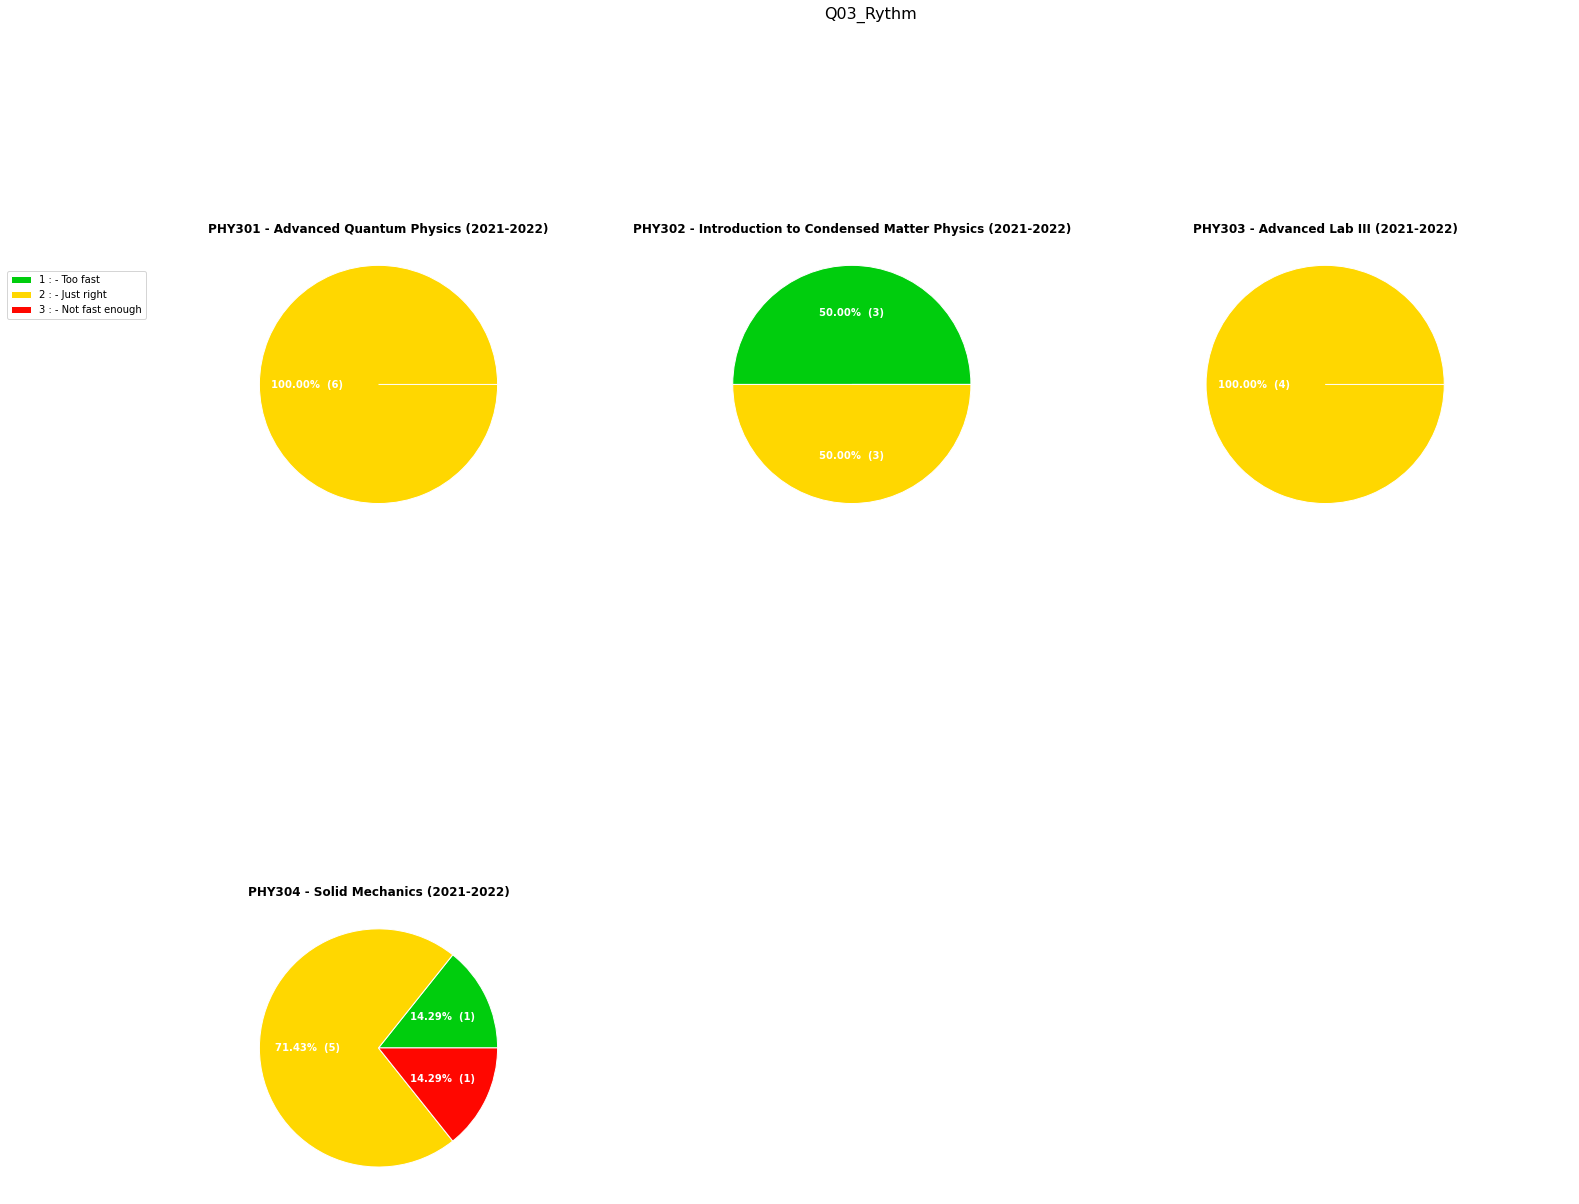

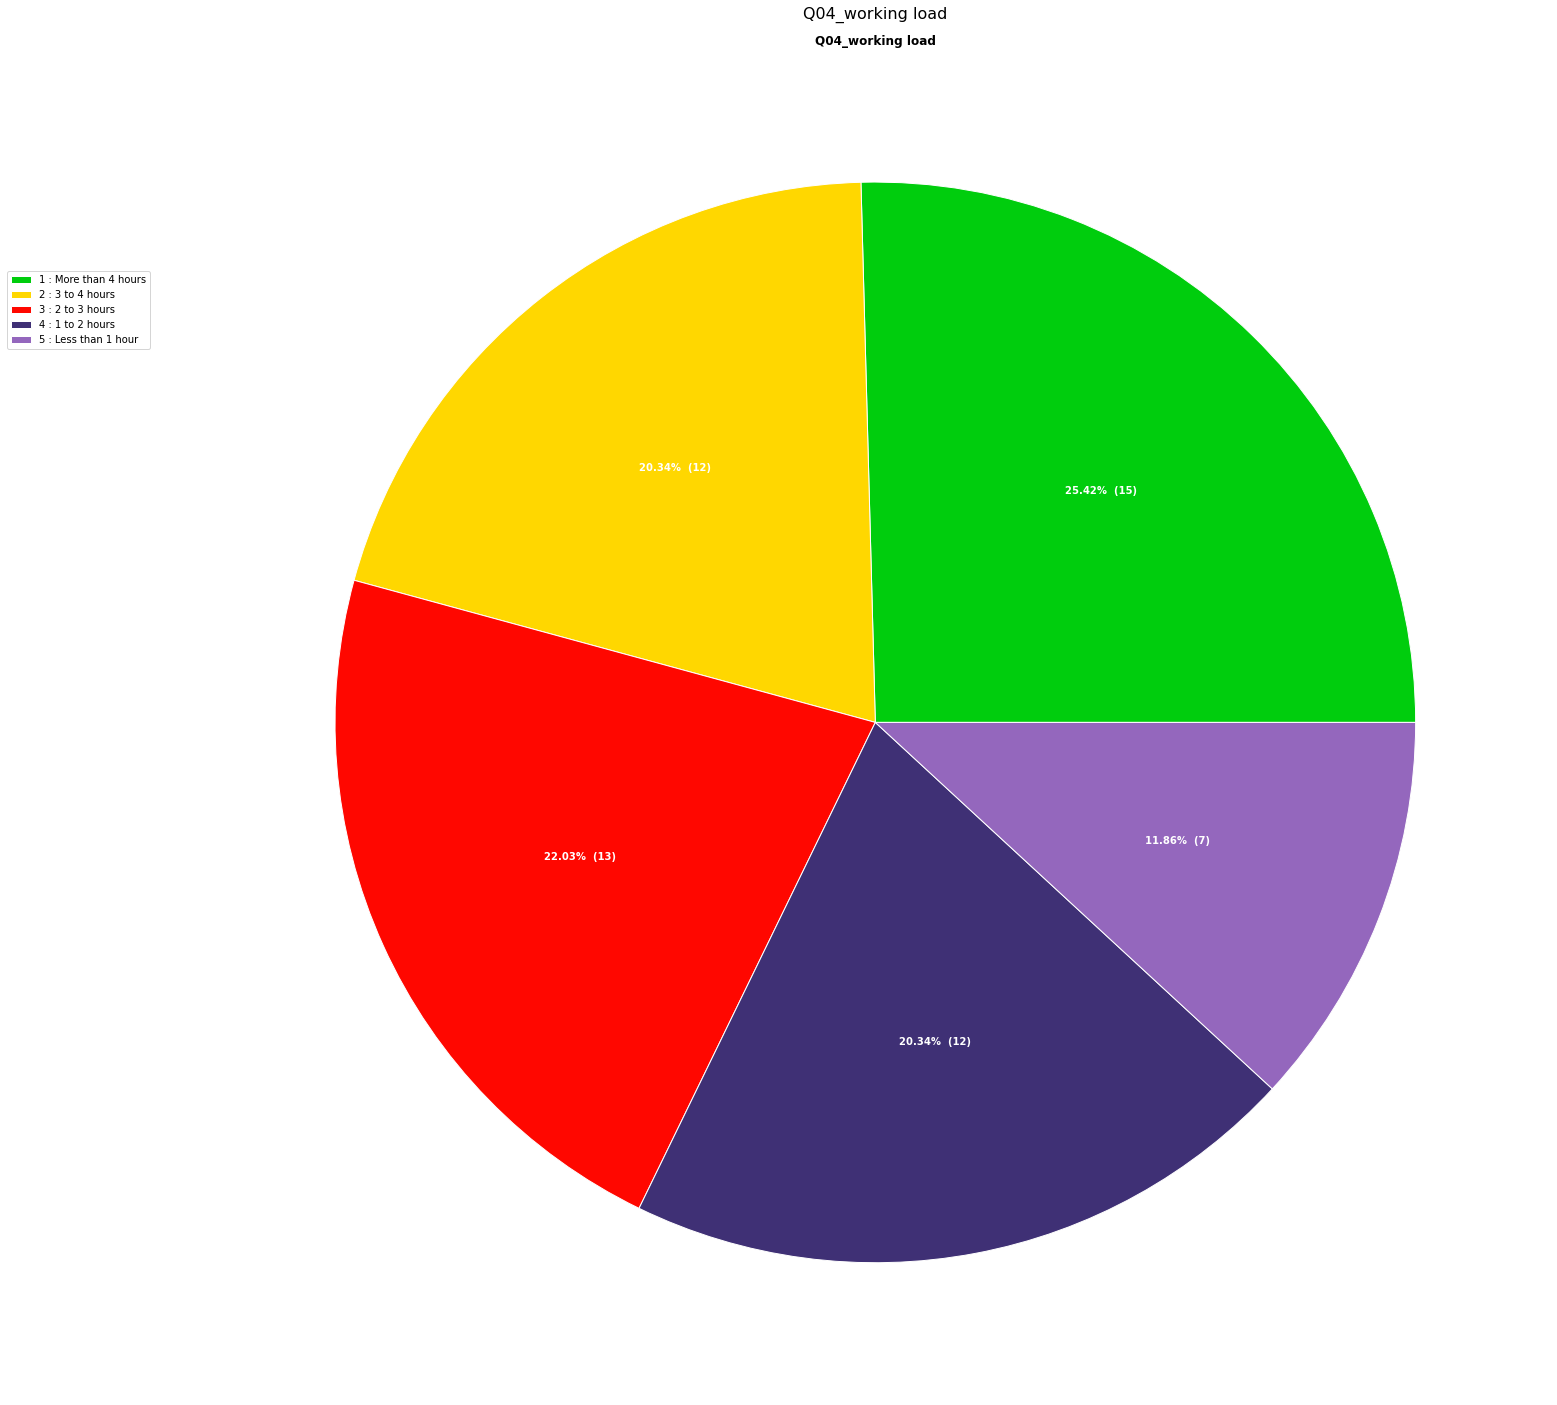

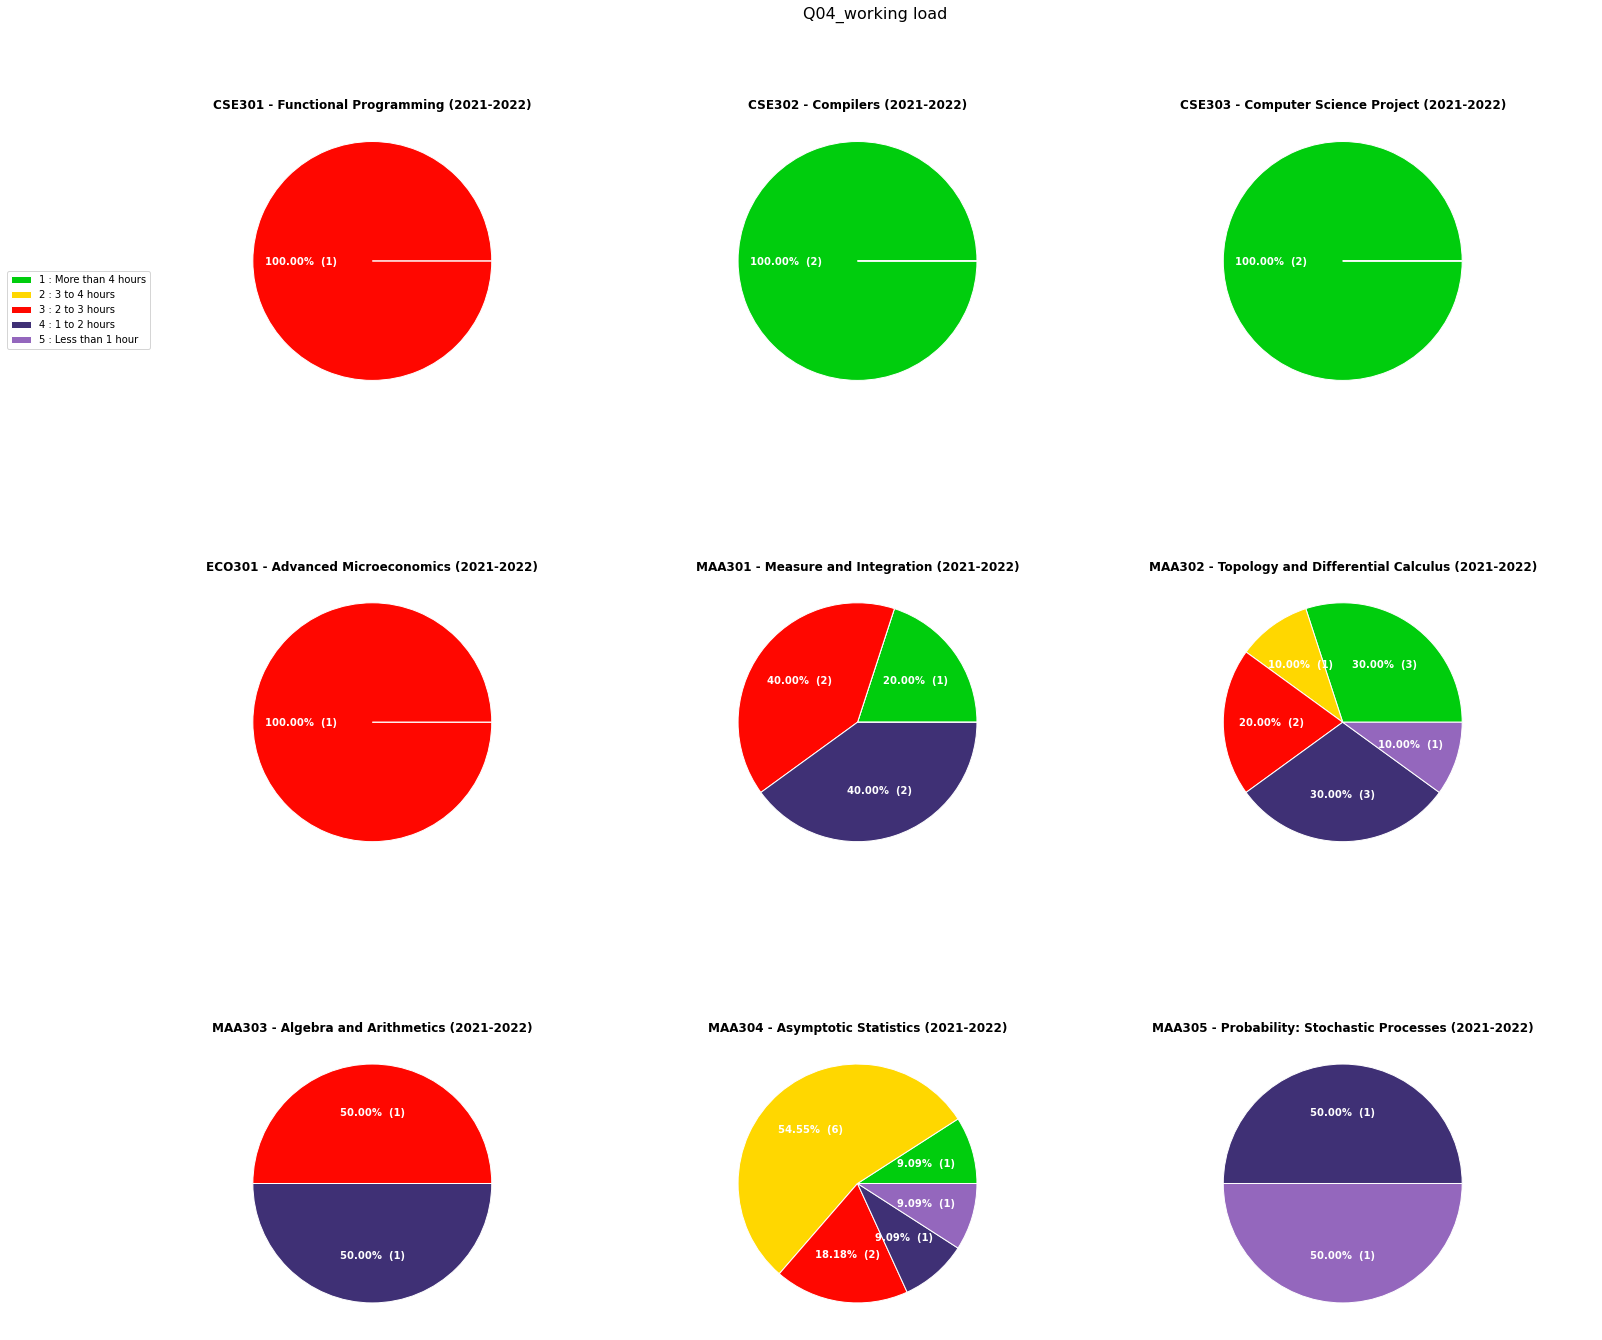

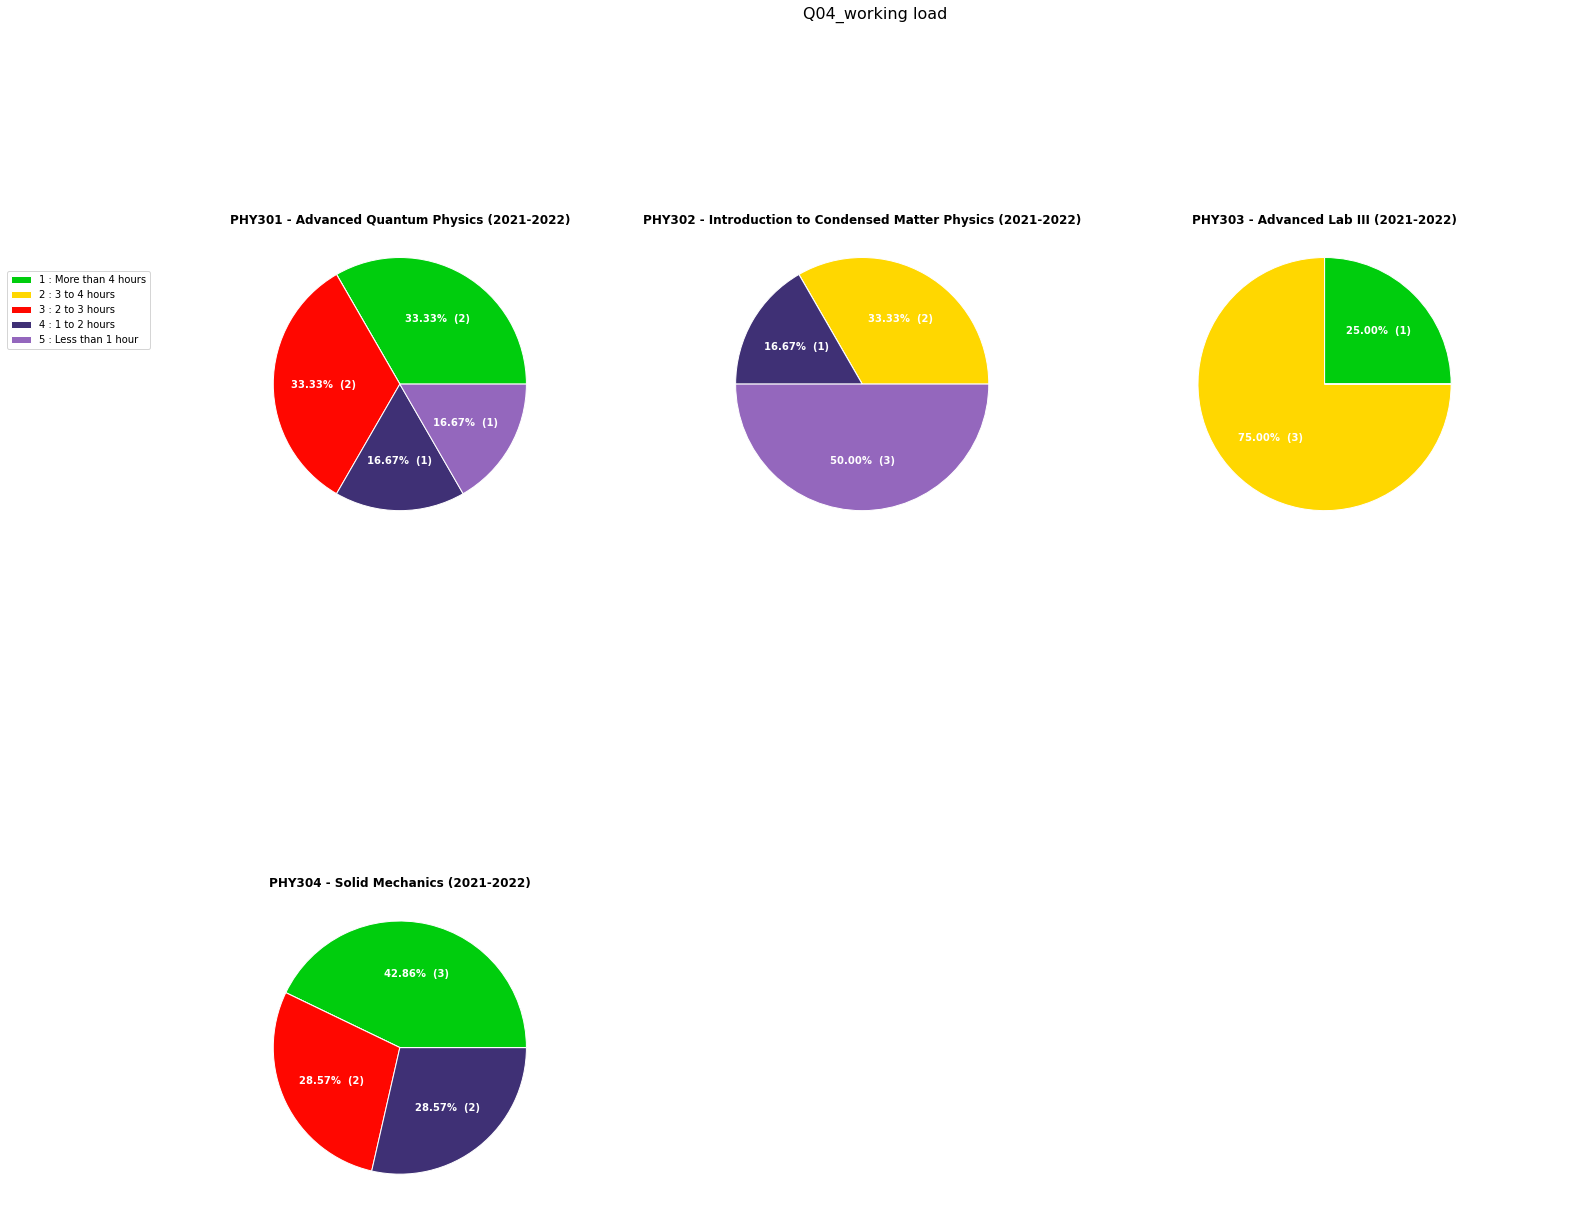

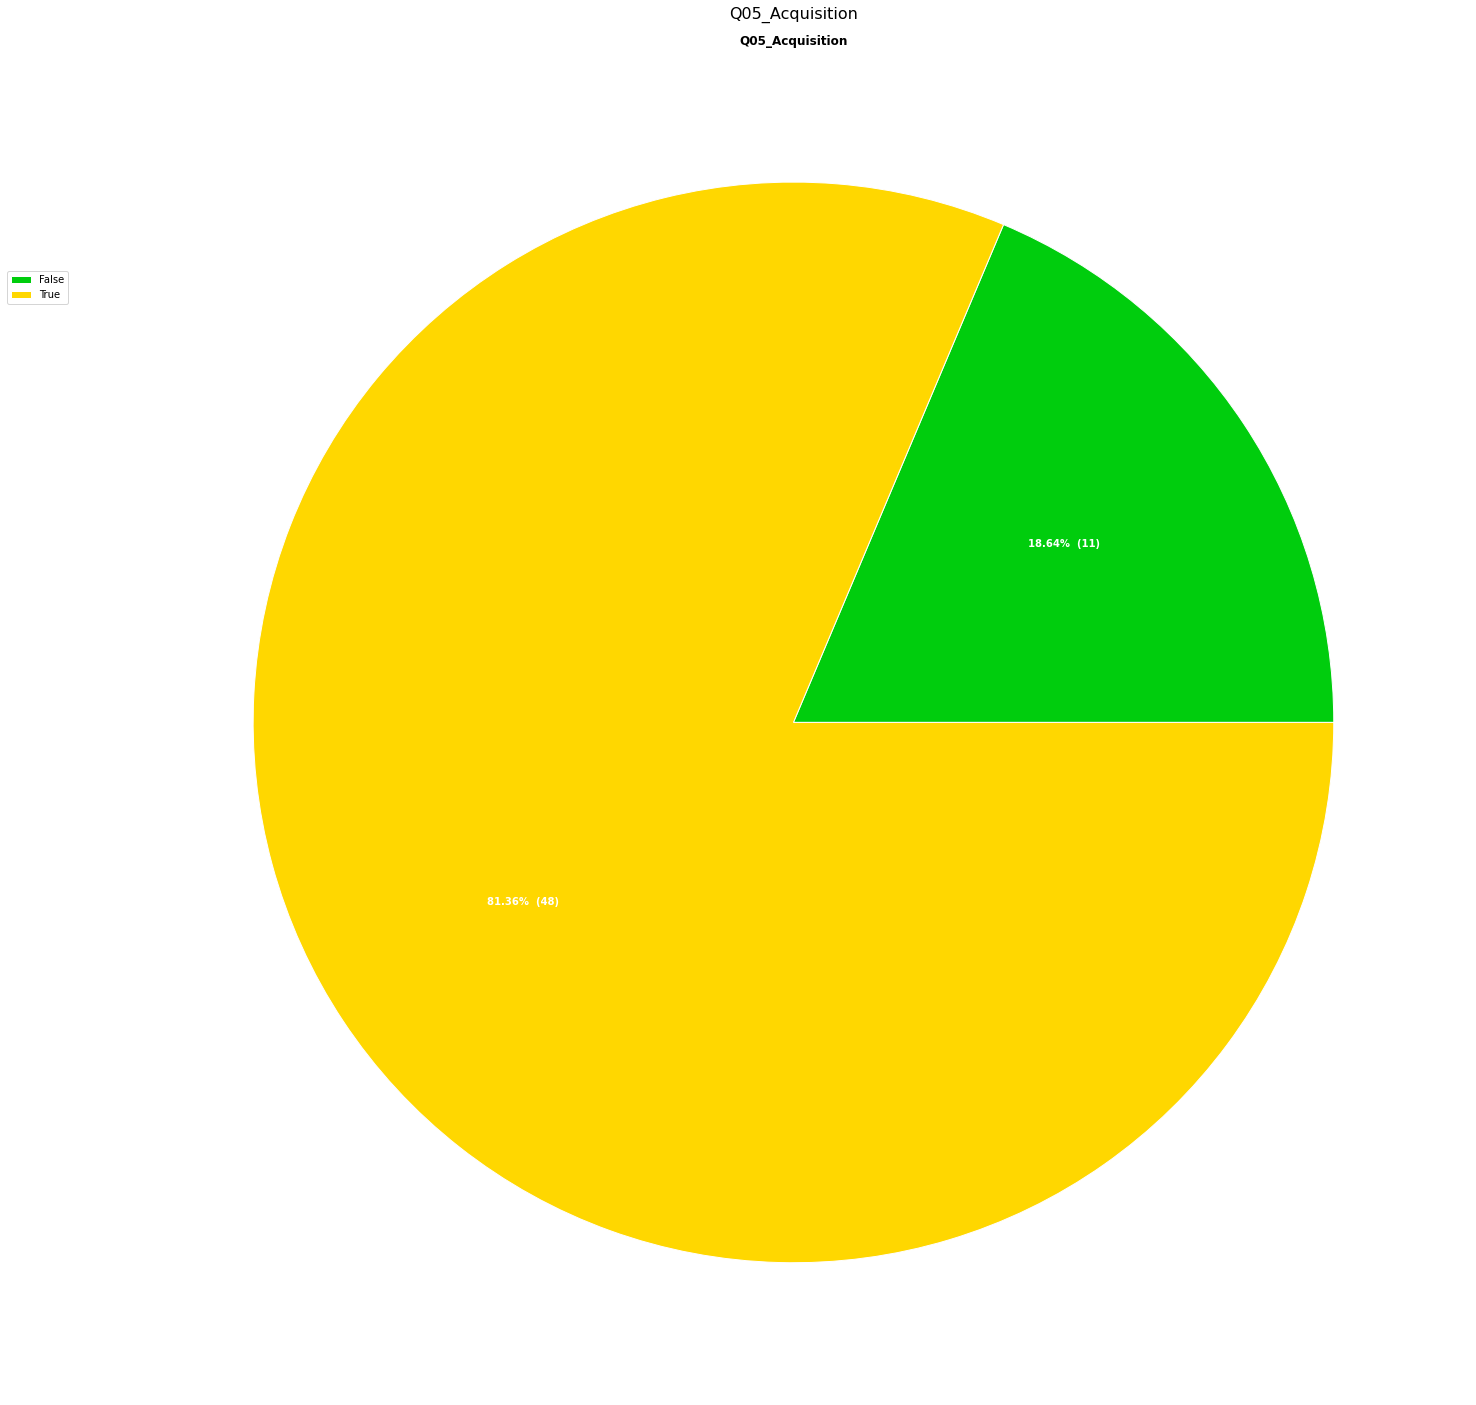

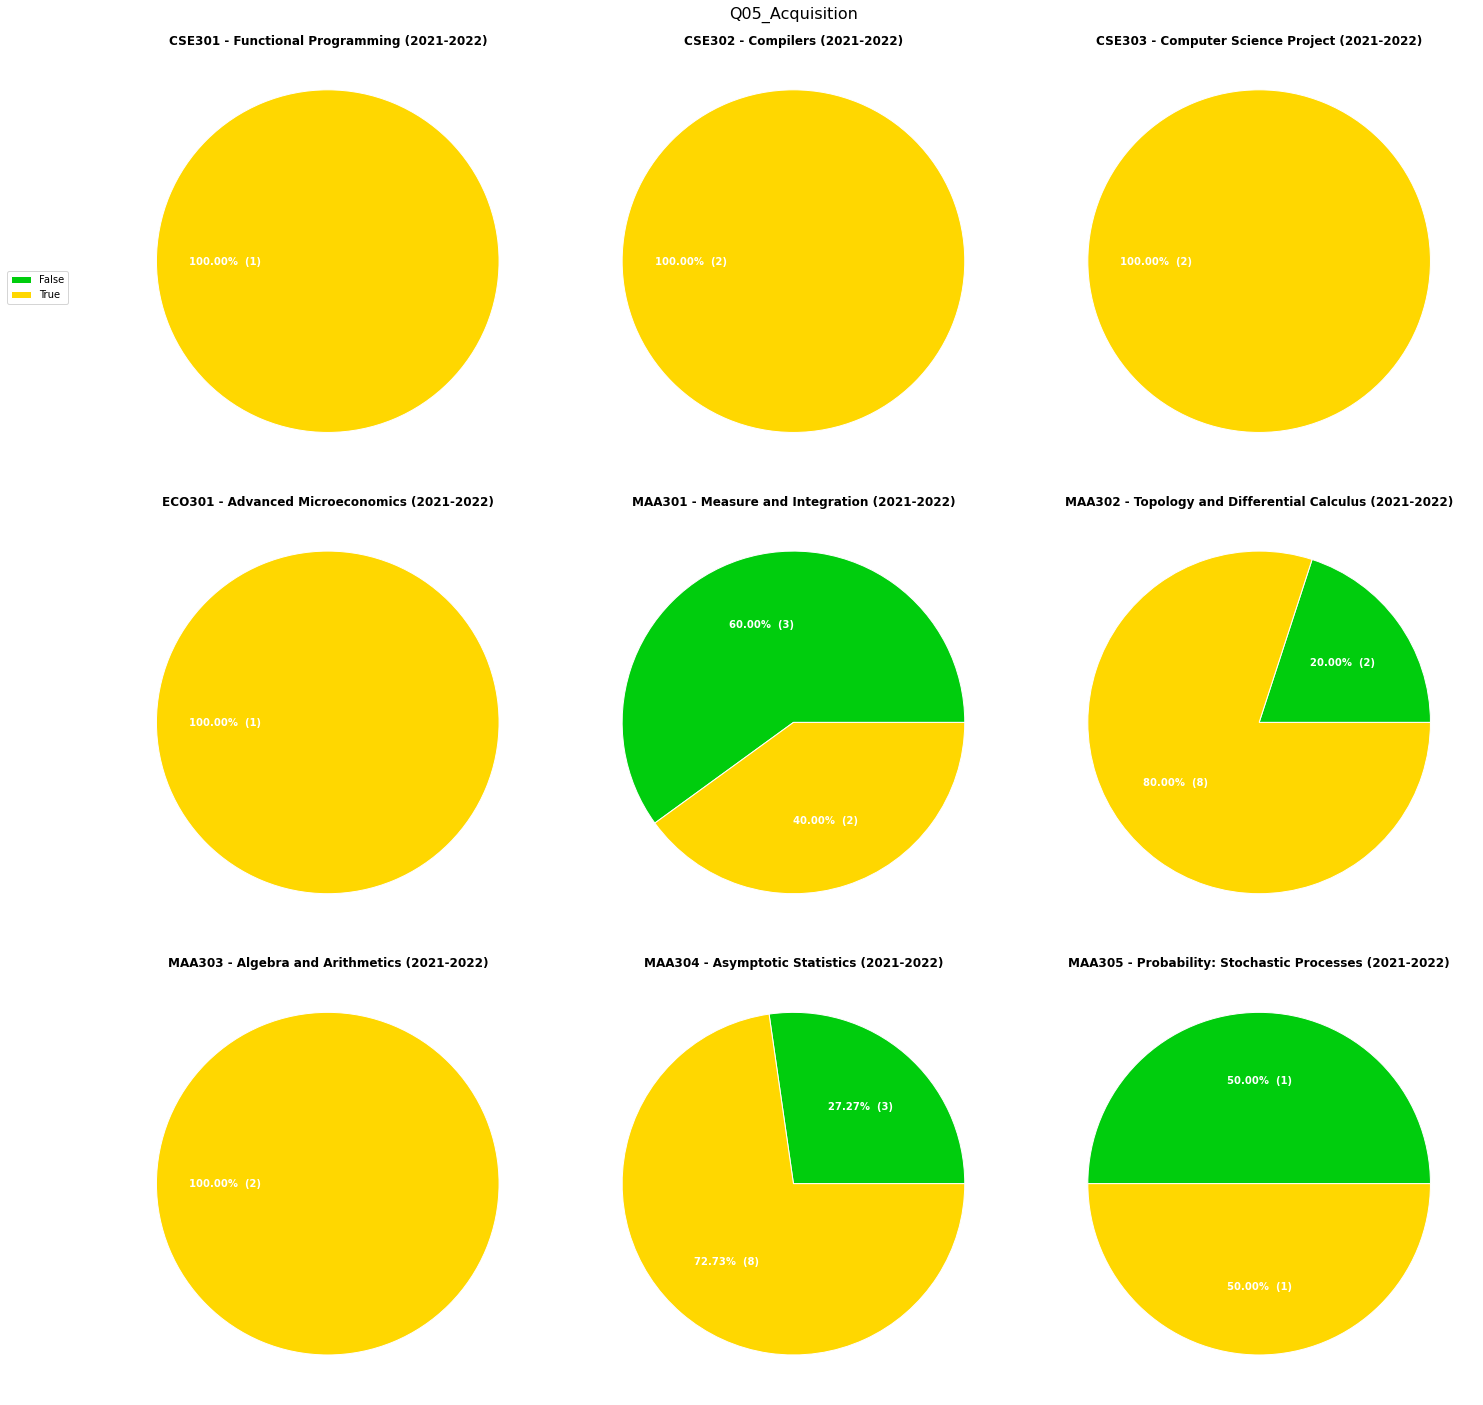

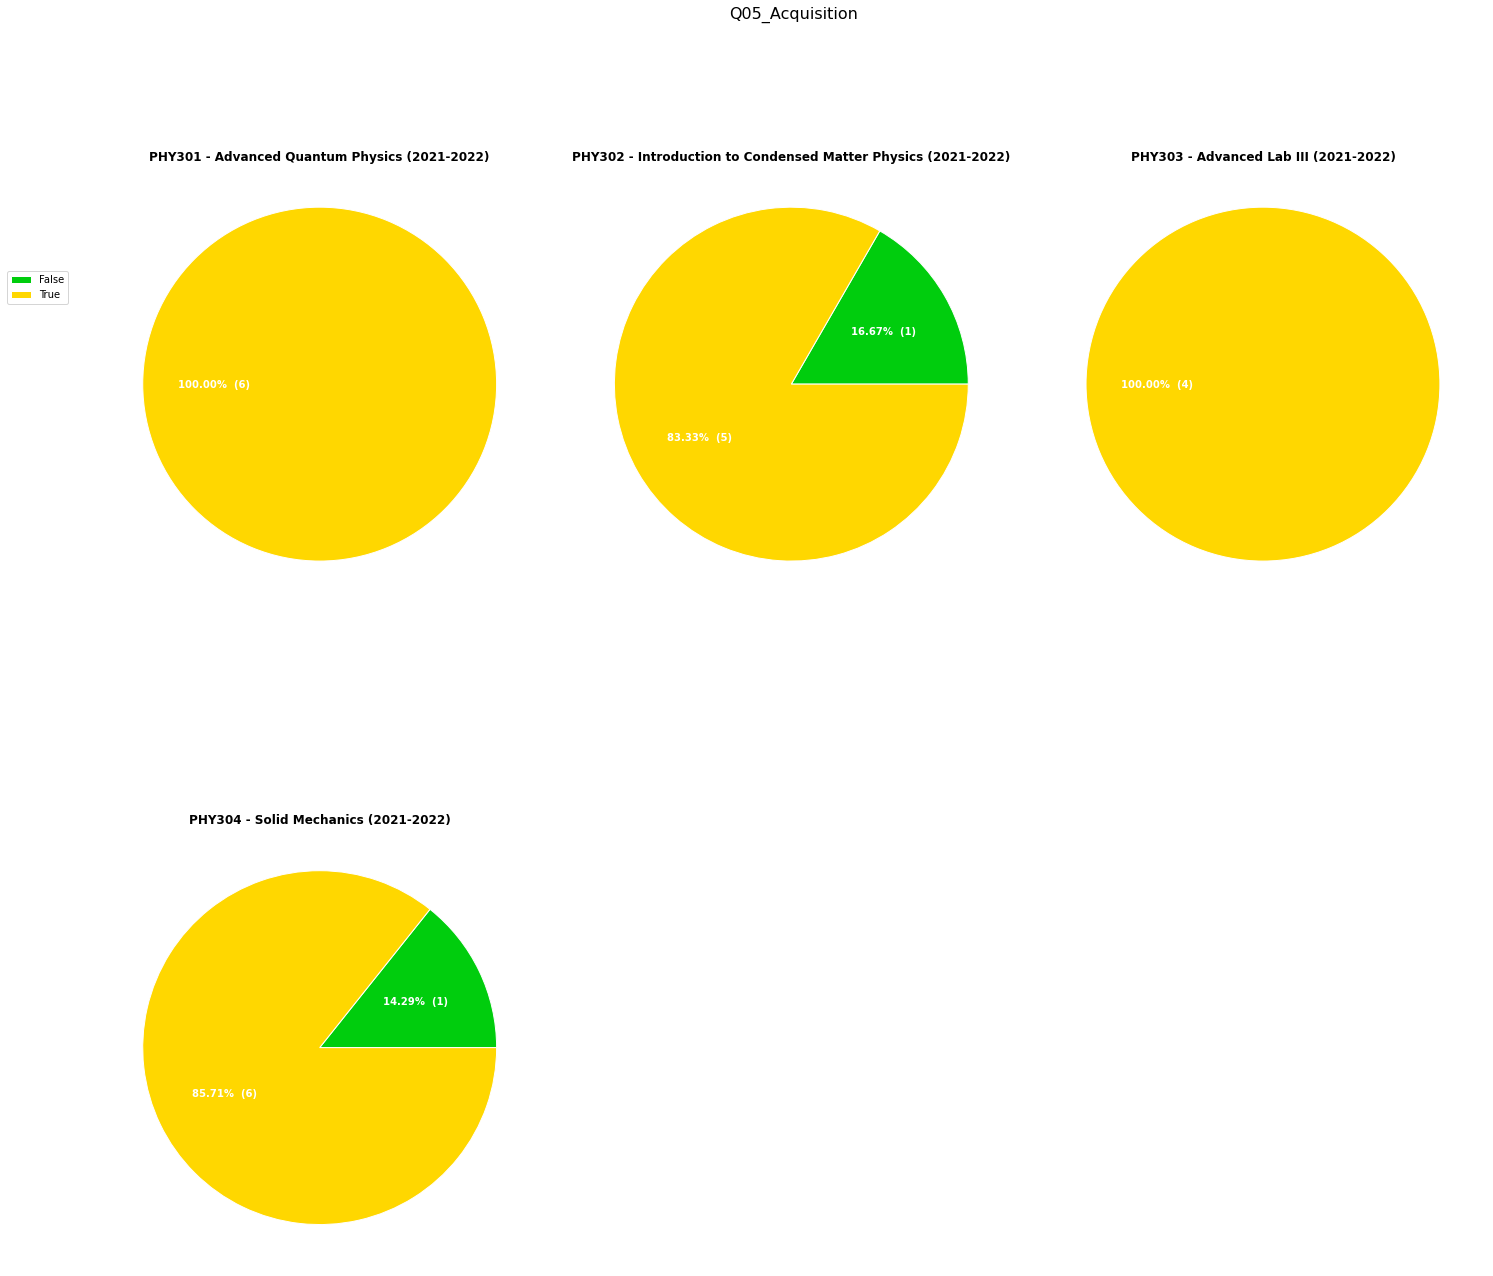

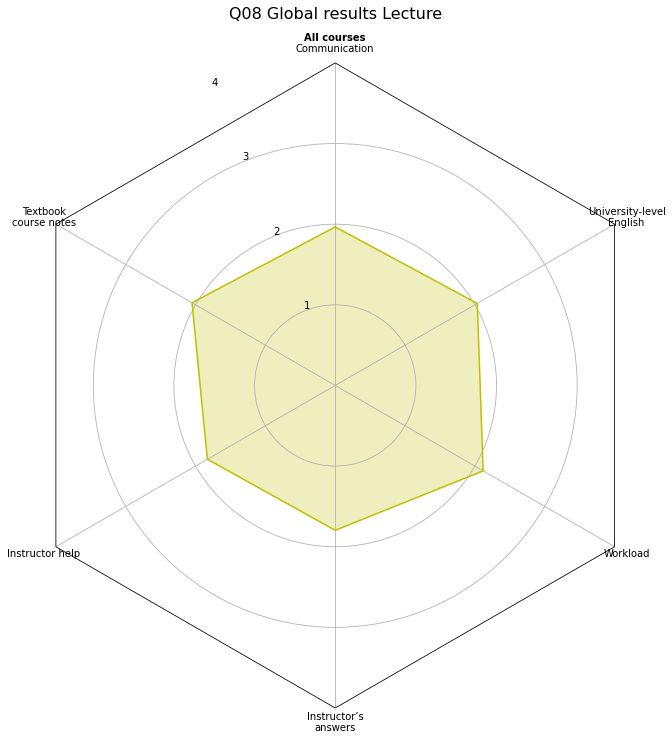

The instructor was effective in communicating the content of the course
The textbook/course notes provided were of high quality and helped the understanding of the topics covered in the course
The instructor was interested in helping students. He encouraged discussions and responded to students' questions
Instructor’s answers to students’questions were accurate
The instructor distributed the workload evenly
Courses content was presented in university-level English


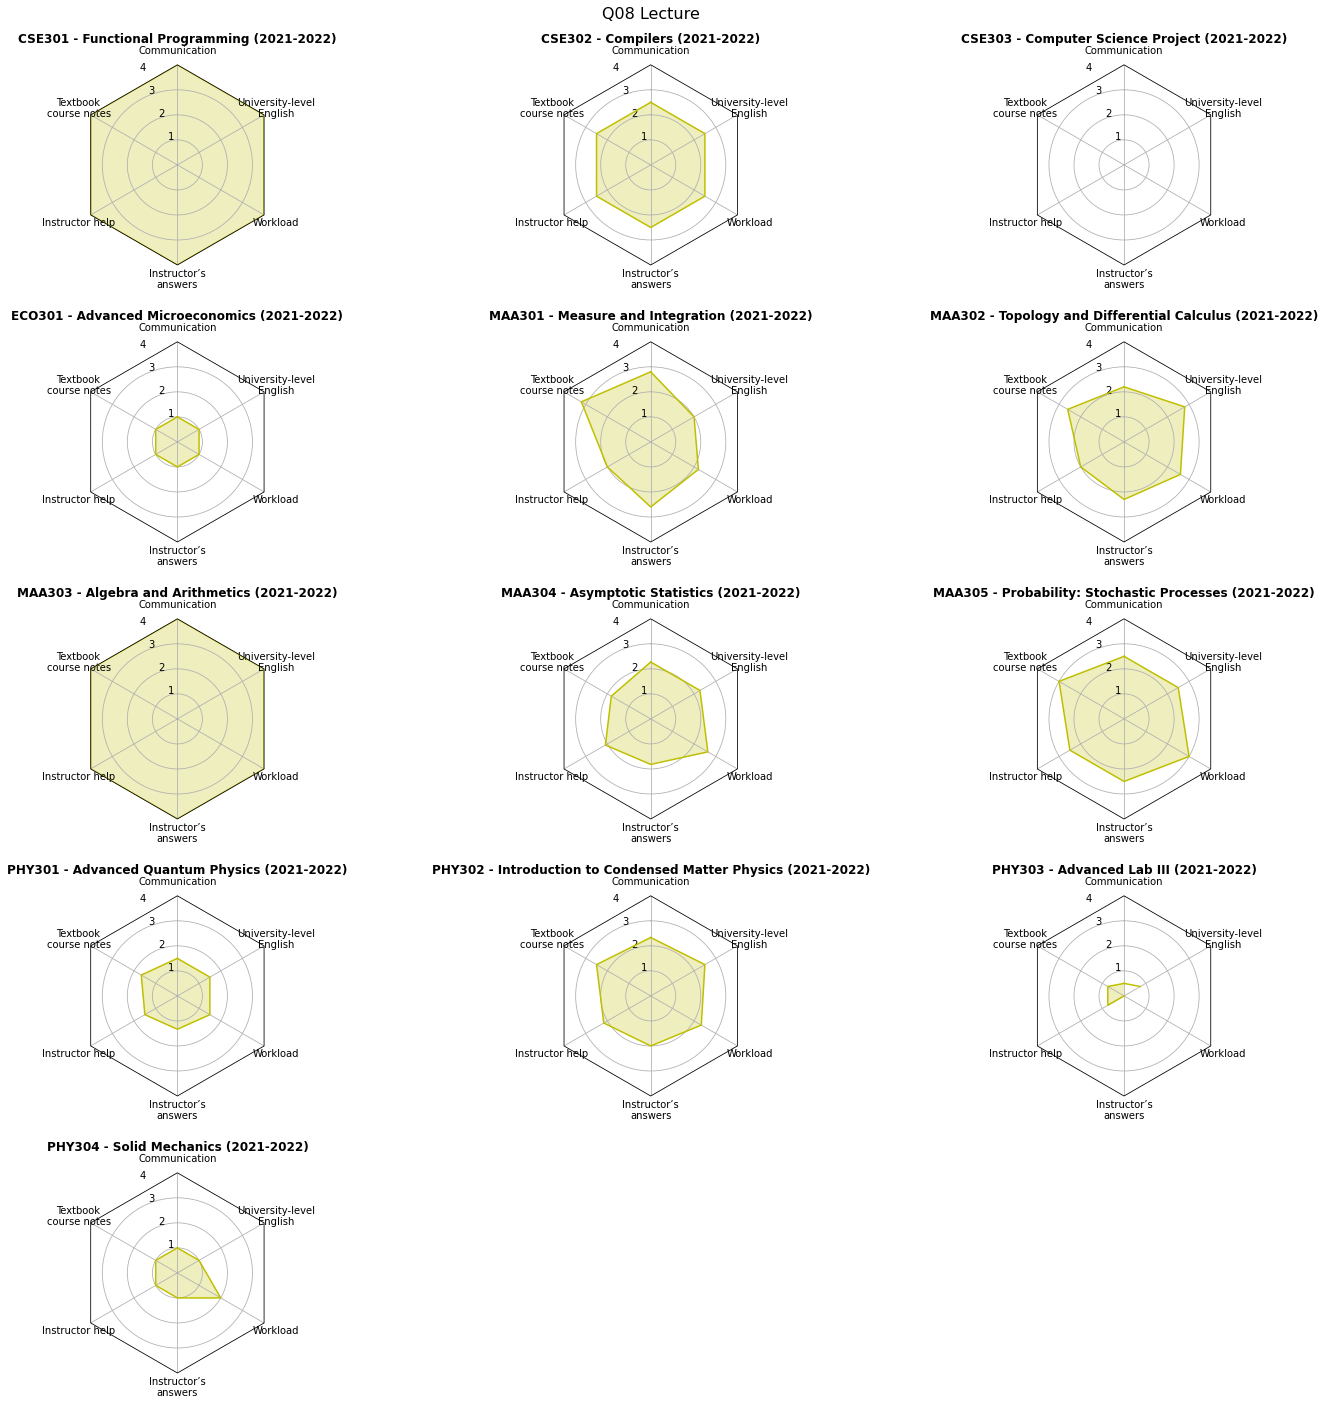

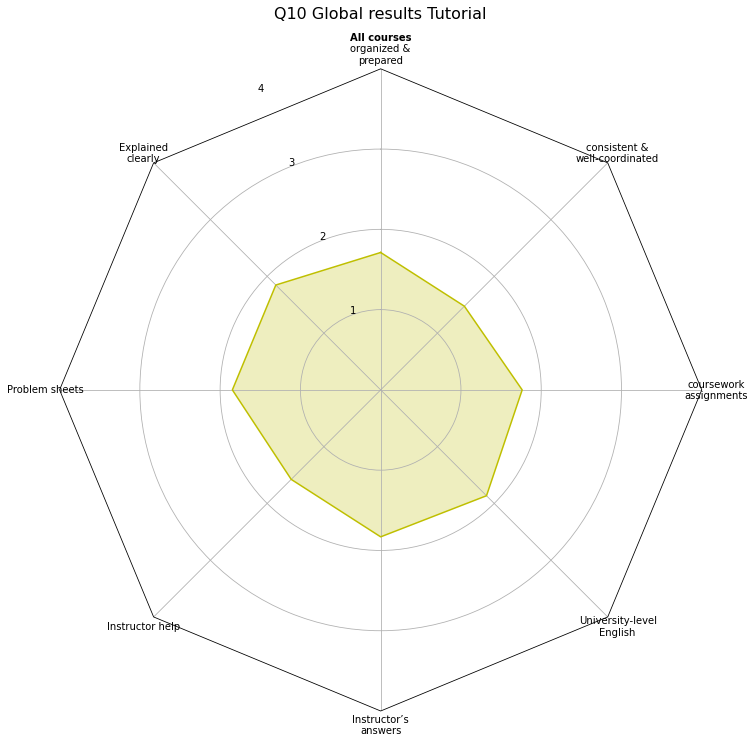

The tutorial instructor was organized and prepared for every class
The tutorial instructor explained the material/exercices clearly
The content and volume of the problem sheets helped advance the understanding of the subject matter
The tutorial instructor was interested in helping students and answered to students' questions
Tutorial instructor’s answers to students’ questions were accurate
Tutorials content was presented in university-level English
The coursework/assignments covered in tutorials/labs were effective in that they helped advance my understanding of the subject matter
If applicable (not for labs): topics covered in lectures and tutorials were consistent and well-coordinated


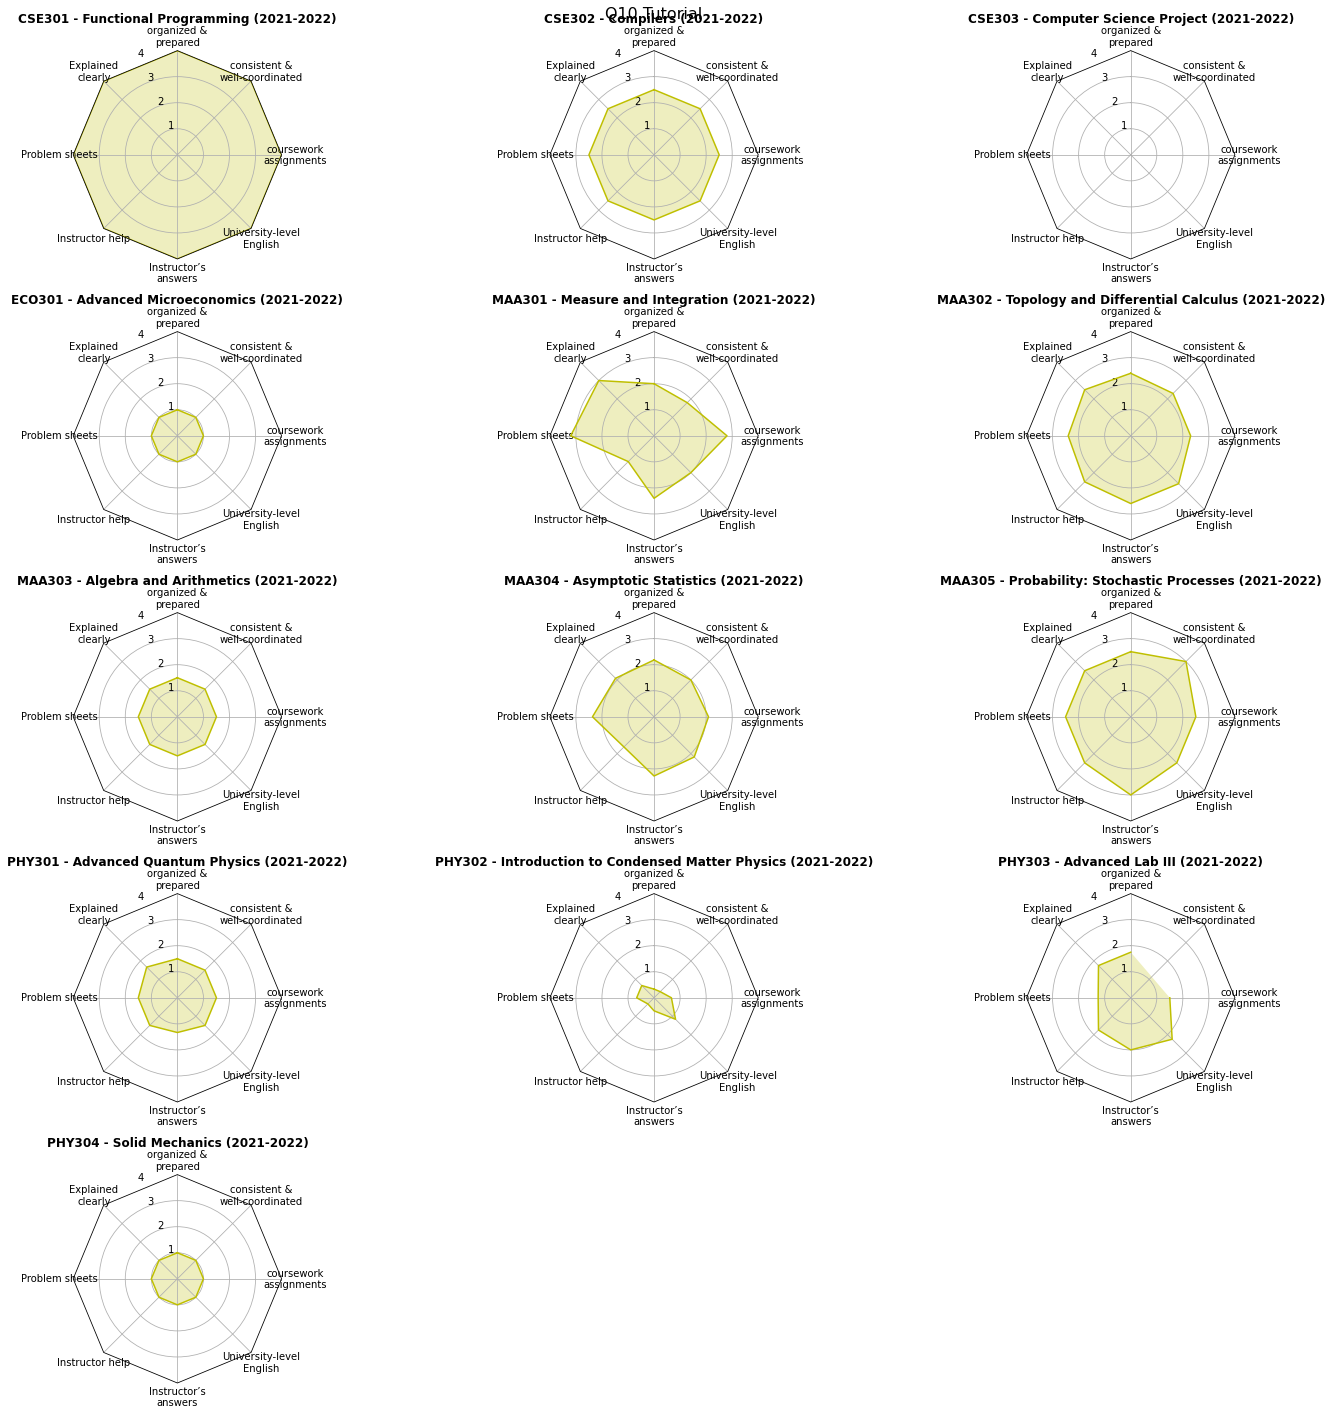

In [8]:
# Crée un fichier pdf
pdf = PdfPages('Bachelor Report.pdf')

# dessine le camembert Q1
# Passe le texte de la question, le nb max d'élément par page, le fichier pdf
QPie('Q01', 9, pdf)

#--------------------
# dessine Q2
# Extrait les colonnes et calcul la moyenne
col = [q for q in data.columns if 'Q02' in q]

categories = ['expectations','objectives\nachieved','level','homeworks and controls','evaluations']
#valeurs = ('Global',[data[col].mean().tolist()])
val1= ('chart 1',[data[col].mean().tolist()])
val2 = ('chart 2',[data[col].mean().tolist()])
#mydata = [categories,val1,val2]
mydata = [categories,val1]
#print(mydata)
N = len(mydata[0])
theta = radar_factory(N, frame='polygon')
#theta = radar_factory(N, frame='circle')

spoke_labels = mydata.pop(0)
    
fig, axs = plt.subplots(figsize=(20,20), nrows=2, ncols=1,
                        subplot_kw=dict(projection='radar'))
#fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)
fig.subplots_adjust(wspace=0.25,hspace=0.25,top=0.85,bottom=0.1)
#fig.set_size_inches(8, 11)

colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf','#1a55FF']

# Plot the four cases from the example data on separate axes
for ax, (title, case_data) in zip(axs.flat, mydata):
    ax.set_rgrids([1, 2, 3, 4])
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                 horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        #print(theta, d, color)
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.25)
        ax.set_varlabels(spoke_labels)
        ax.set_ylim(bottom=0,top=4)

# add legend relative to top-left plot
labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
#legend = axs[0, 0].legend(labels, loc=(0.9, .95),
#                          labelspacing=0.1, fontsize='small')

plt.yticks([1,2,3,4],color="grey", size=10)

fig.text(0.5, 0.965, 'Question 2',
         horizontalalignment='center', color='black', weight='bold',
         size='large')

# supprime le deuxième (vide)
fig.delaxes(axs[1])

fig.tight_layout(pad=2.0)
plt.show()
pdf.savefig(fig, bbox_inches="tight")
#fig.savefig('Q2_1.png', dpi=100, transparent=True)

#-----------------------
# Génération des moyennes Q2 par cours
col = [q for q in data.columns if 'Q02' in q]
col.append('Cours')
df = data[col].groupby('Cours').mean()

"""
# Affiche le texte des questions de lickert
for q in data.columns :
    if 'Q02' in q:
        print(question(q))
"""

mydata=[categories]
for (titre, values) in df.iterrows():
    mydata.append((titre,[values.tolist()]))
#print(mydata)

N = len(mydata[0])
theta = radar_factory(N, frame='polygon')
#theta = radar_factory(N, frame='circle')

# on extrait de la liste les titres
spoke_labels = mydata.pop(0)

# nb de graphe par ligne
ncols = 3
# calcul du nombre de lignes
nb_graph = len(df)
if len(df) %ncols == 0:
    nrows = int(len(df)/ncols)
else:
    nrows = int(len(df)/ncols)+1
    
fig, axs = plt.subplots(figsize=(20,20), nrows=nrows, ncols=ncols,
                        subplot_kw=dict(projection='radar'))
#fig.subplots_adjust(wspace=0.25, hspace=0.20, top=2, bottom=0.05)
fig.subplots_adjust(wspace=0.25,hspace=0.25,top=0.85,bottom=0.1)

colors = ['y', 'r', 'g', 'm', 'b']

# Plot the four cases from the example data on separate axes
for ax, (title, case_data) in zip(axs.flat, mydata):
    ax.set_rgrids([1, 2, 3, 4])
    ax.set_title(title, weight='bold', size='large', position=(0.5, 1.1),
                 horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        #print(theta, d, color)
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.25)
        ax.set_varlabels(spoke_labels)
        ax.set_ylim(bottom=0,top=4)

# add legend relative to top-left plot
labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
#legend = axs[0, 0].legend(labels, loc=(0.9, .95),
#                          labelspacing=0.1, fontsize='small')


fig.text(0.5, 0.965, 'Bachelor Q2',
         horizontalalignment='center', color='black', weight='bold',
         size='large')

# supprime les derniers graphes vides
if len(df) %ncols != 0:
    for n in range(ncols,len(df) %ncols,-1):
        fig.delaxes(axs[nrows-1,n-1])

fig.tight_layout(pad=2.0)
plt.show()
pdf.savefig(fig, bbox_inches="tight")
#fig.savefig('Q2_2.png', dpi=100, transparent=True)

#--------------------------------------Q3
# dessine le camembert Q3
QPie('Q03', 9, pdf)

#--------------------------------------Q4
# dessine le camembert Q4
QPie('Q04', 9, pdf)

#--------------------------------------Q5
# transforme Q5  en True / False
data[[q for q in data.columns if 'Q05' in q][0]] = data[[q for q in data.columns if 'Q05' in q][0]].astype(bool)

# dessine le camembert Q5
QPie('Q05', 9, pdf)

#--------------------------------------Q8
# Extrait les colonnes et calcul la moyenne
col = [q for q in data.columns if 'Q08' in q]

categories = ['Communication','Textbook\ncourse notes','Instructor help','Instructor’s\nanswers','Workload','University-level\nEnglish']
val1= ('All courses',[data[col].mean().tolist()])
val2 = ('chart 2',[data[col].mean().tolist()])
#mydata = [categories,val1,val2]
mydata = [categories,val1]
#print(mydata)

N = len(mydata[0])
theta = radar_factory(N, frame='polygon')
#theta = radar_factory(N, frame='circle')

spoke_labels = mydata.pop(0)
    
fig, axs = plt.subplots(figsize=(20,20), nrows=2, ncols=1,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25,hspace=0.25,top=0.85,bottom=0.1)

colors = ['y', 'r', 'g', 'm', 'b']

# Plot the four cases from the example data on separate axes
for ax, (title, case_data) in zip(axs.flat, mydata):
    ax.set_rgrids([1, 2, 3, 4])
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                 horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        #print(theta, d, color)
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.25)
        ax.set_varlabels(spoke_labels)
        ax.set_ylim(bottom=0,top=4)

# add legend relative to top-left plot
labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
#legend = axs[0, 0].legend(labels, loc=(0.9, .95),
#                          labelspacing=0.1, fontsize='small')

plt.yticks([1,2,3,4],color="grey", size=10)

#fig.text(0.5, 0.965, 'Q8 Global results',horizontalalignment='center', color='black', weight='bold',size='large')
fig.suptitle('Q08 Global results Lecture',fontsize=16, verticalalignment='top', horizontalalignment='center')

# supprime le deuxième (vide)
fig.delaxes(axs[1])

fig.tight_layout(pad=2.0)
plt.show()
pdf.savefig(fig, bbox_inches="tight")


#------
# Génération des moyennes par cours
col = [q for q in data.columns if 'Q08' in q]
col.append('Cours')
df = data[col].groupby('Cours').mean()
#print(d.values.tolist())
data[col].groupby('Cours').mean()

# Affiche le texte des questions de lickert
for q in data.columns :
    if 'Q08' in q:
        print(question(q))

mydata=[categories]
for (titre, values) in df.iterrows():
    mydata.append((titre,[values.tolist()]))
#print(mydata)

N = len(mydata[0])
theta = radar_factory(N, frame='polygon')
#theta = radar_factory(N, frame='circle')

# on extrait de la liste les titres
spoke_labels = mydata.pop(0)

# nb de graphe par ligne
ncols = 3
# calcul du nombre de lignes
nb_graph = len(df)
if len(df) %ncols == 0:
    nrows = int(len(df)/ncols)
else:
    nrows = int(len(df)/ncols)+1
    
fig, axs = plt.subplots(figsize=(20,20), nrows=nrows, ncols=ncols,
                        subplot_kw=dict(projection='radar'))
#fig.subplots_adjust(wspace=0.25, hspace=0.20, top=2, bottom=0.05)
fig.subplots_adjust(wspace=0.25,hspace=0.25,top=0.80,bottom=0.1)                    


colors = ['y', 'r', 'g', 'm', 'b']

# Plot the four cases from the example data on separate axes
for ax, (title, case_data) in zip(axs.flat, mydata):
    ax.set_rgrids([1, 2, 3, 4])
    ax.set_title(title, weight='bold', size='large', position=(0.5, 1.1),
                 horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        #print(theta, d, color)
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.25)
        ax.set_varlabels(spoke_labels)
        ax.set_ylim(bottom=0,top=4)

# add legend relative to top-left plot
labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
#legend = axs[0, 0].legend(labels, loc=(0.9, .95),
#                          labelspacing=0.1, fontsize='small')


#fig.text(0.5, 0.965, 'Q8', horizontalalignment='center', color='black', weight='bold', size='large')
fig.suptitle('Q08 Lecture',fontsize=16, verticalalignment='top', horizontalalignment='center')

# supprime les derniers graphes vides
if len(df) %ncols != 0:
    for n in range(ncols,len(df) %ncols,-1):
        fig.delaxes(axs[nrows-1,n-1])
    
fig.tight_layout(pad=2.0)
plt.show()
pdf.savefig(fig, bbox_inches="tight")

#--------------------------------------Q10
# Extrait les colonnes et calcul la moyenne
col = [q for q in data.columns if 'Q10' in q]

categories = ['organized &\nprepared','Explained\nclearly','Problem sheets','Instructor help','Instructor’s\nanswers','University-level\nEnglish','coursework\nassignments','consistent &\nwell-coordinated']
#valeurs = ('Global',[data[col].mean().tolist()])
val1= ('All courses',[data[col].mean().tolist()])
val2 = ('chart 2',[data[col].mean().tolist()])
#mydata = [categories,val1,val2]
mydata = [categories,val1]
#print(mydata)

N = len(mydata[0])
theta = radar_factory(N, frame='polygon')
#theta = radar_factory(N, frame='circle')

spoke_labels = mydata.pop(0)
    
fig, axs = plt.subplots(figsize=(20,20), nrows=2, ncols=1,
                        subplot_kw=dict(projection='radar'))
#fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)
fig.subplots_adjust(wspace=0.25,hspace=0.25,top=0.85,bottom=0.1)                    

colors = ['y', 'r', 'g', 'm', 'b']

# Plot the four cases from the example data on separate axes
for ax, (title, case_data) in zip(axs.flat, mydata):
    ax.set_rgrids([1, 2, 3, 4])
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                 horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        #print(theta, d, color)
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.25)
        ax.set_varlabels(spoke_labels)
        ax.set_ylim(bottom=0,top=4)

# add legend relative to top-left plot
labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
#legend = axs[0, 0].legend(labels, loc=(0.9, .95),
#                          labelspacing=0.1, fontsize='small')

plt.yticks([1,2,3,4],color="grey", size=10)

#fig.text(0.5, 0.965, 'Q10 Global results',horizontalalignment='center', color='black', weight='bold',size='large')
fig.suptitle('Q10 Global results Tutorial',fontsize=16, verticalalignment='top', horizontalalignment='center')

# supprime le deuxième (vide)
fig.delaxes(axs[1])

fig.tight_layout(pad=2.0)
plt.show()
pdf.savefig(fig, bbox_inches="tight")

# Génération des moyennes par cours
col = [q for q in data.columns if 'Q10' in q]
col.append('Cours')
df = data[col].groupby('Cours').mean()
#print(d.values.tolist())
data[col].groupby('Cours').mean()
# Affiche le texte des questions de lickert
for q in data.columns :
    if 'Q10' in q:
        print(question(q))

mydata=[categories]
for (titre, values) in df.iterrows():
    mydata.append((titre,[values.tolist()]))
#print(mydata)

N = len(mydata[0])
theta = radar_factory(N, frame='polygon')
#theta = radar_factory(N, frame='circle')

# on extrait de la liste les titres
spoke_labels = mydata.pop(0)

# nb de graphe par ligne
ncols = 3
# calcul du nombre de lignes
nb_graph = len(df)
if len(df) %ncols == 0:
    nrows = int(len(df)/ncols)
else:
    nrows = int(len(df)/ncols)+1
    
fig, axs = plt.subplots(figsize=(20,20), nrows=nrows, ncols=ncols,
                        subplot_kw=dict(projection='radar'))
#fig.subplots_adjust(wspace=0.25, hspace=0.20, top=2, bottom=0.05)
#fig.subplots_adjust(wspace=0.3,hspace=0.20,top=0.8,bottom=0.2)
fig.subplots_adjust(wspace=0.25,hspace=0.25,top=0.8,bottom=0.05)     

colors = ['y', 'r', 'g', 'm', 'b']

# Plot the four cases from the example data on separate axes
for ax, (title, case_data) in zip(axs.flat, mydata):
    ax.set_rgrids([1, 2, 3, 4])
    ax.set_title(title, weight='bold', size='large', position=(0.5, 1.1),
                 horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        #print(theta, d, color)
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.25)
        ax.set_varlabels(spoke_labels)
        ax.set_ylim(bottom=0,top=4)

# add legend relative to top-left plot
#labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
#legend = axs[0, 0].legend(labels, loc=(0.9, .95),
#                          labelspacing=0.1, fontsize='small')


#fig.text(0.5, 0.965, 'Q10',horizontalalignment='center', color='black', weight='bold', size='large')
fig.suptitle('Q10 Tutorial',fontsize=16, verticalalignment='top', horizontalalignment='center')

# supprime les derniers graphes vides
if len(df) %ncols != 0:
    for n in range(ncols,len(df) %ncols,-1):
        fig.delaxes(axs[nrows-1,n-1])
    
fig.tight_layout(pad=1.0)
plt.show()
pdf.savefig(fig, bbox_inches="tight")

# ferme le fichier pdf
pdf.close()